In [1]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import time

import torch
import scipy.sparse
from torch import Tensor
from torch.utils.dlpack import to_dlpack, from_dlpack

import torch_geometric.data
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.utils import is_undirected, to_undirected

from pgmpy.estimators.CITests import chi_square
from scipy.special import softmax



In [2]:
G1 = nx.Graph()
G1.add_nodes_from([1, 2, 3])
G1.add_edges_from([(1, 2), (1, 3), (2, 3)])
print(G1)

Graph with 3 nodes and 3 edges


In [3]:
list(G1.edges)

[(1, 2), (1, 3), (2, 3)]

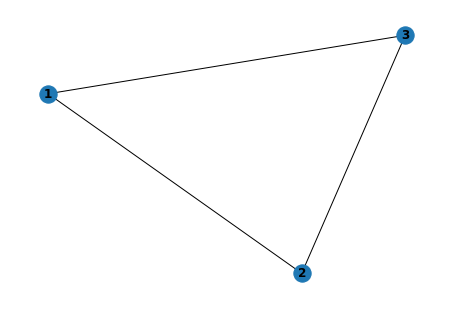

In [4]:
nx.draw(G1, with_labels=True, font_weight='bold')

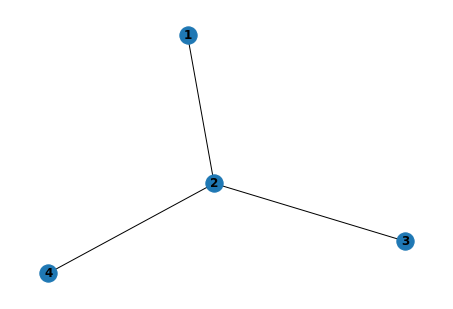

In [5]:
G2 = nx.Graph()
G2.add_nodes_from([1, 2, 3, 4])
G2.add_edges_from([(1, 2), (2, 3), (2, 4)])
nx.draw(G2, with_labels=True, font_weight='bold')

In [7]:
g_int = nx.intersection(G1, G2)

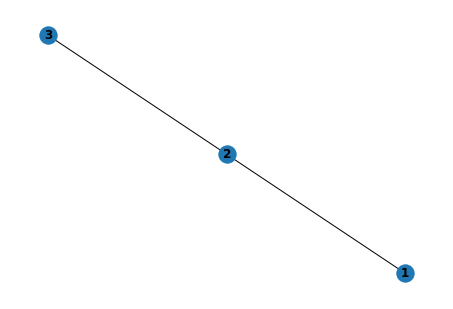

In [8]:
g_int.remove_nodes_from(list(nx.isolates(g_int)))
nx.draw(g_int, with_labels=True, font_weight='bold')


In [9]:
n_tp = g_int.number_of_edges()
n_tp

2

In [10]:
n_fp = len(G1.edges() - g_int.edges())
n_fp

1

In [11]:
n_fn = len(G2.edges() - g_int.edges())
n_fn

1

In [12]:
G2.edges() - g_int.edges()

{(2, 4)}

In [13]:
precision = n_tp / (n_tp + n_fp)
recall = n_tp / (n_tp + n_fn)
f1_score = 2*(precision * recall)/(precision + recall)
f1_score

0.6666666666666666

In [14]:
nx.graph_edit_distance(G1, G2)

3.0

In [3]:
def ba(n, m, role_start=0):
    G = nx.barabasi_albert_graph(n, m)
    labels = [role_start for i in range(n)]
    return G, labels


def house(start, role_start=1):
    """Builds a house-like  graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    role_start  :    starting index for the roles
    OUTPUT:
    -------------
    graph       :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    """
    graph = nx.Graph()
    graph.add_nodes_from(range(start, start + 5))
    graph.add_edges_from(
        [
            (start, start + 1),
            (start + 1, start + 2),
            (start + 2, start + 3),
            (start + 3, start),
        ]
    )
    graph.add_edges_from([(start + 4, start), (start + 4, start + 1)])
    roles = [role_start, role_start, role_start + 1, role_start + 1, role_start + 2]
    return graph, roles


def build_ba_shapes(n_basis, n_shapes, rdm_basis_plugins=True, rdm_shape_plugins=True, pos=3, add_random_edges=0, m=5):
    # where you will plugin the houses
    # Sample (with replacement) where to attach the new motifs
    if rdm_basis_plugins is True:
        plugins = np.random.choice(n_basis, n_shapes, replace=False)
    else:
        spacing = math.floor(n_basis / n_shapes)
        plugins = [int(k * spacing) for k in range(n_shapes)]

    basis, role_id = ba(n_basis, m)
    start = n_basis
    for shape_id in range(n_shapes):
        graph_s, role_graph_s = house(start)
        n_s = nx.number_of_nodes(graph_s)
        basis.add_nodes_from(graph_s.nodes())
        basis.add_edges_from(graph_s.edges())
        if rdm_shape_plugins is True:
            pos = np.random.choice(range(start, start+n_s))
        basis.add_edges_from([(pos, plugins[shape_id])])
        role_id += role_graph_s
        start += n_s

    if add_random_edges > 0:
        # add random edges between nodes:
        n_rand = int(n_basis*add_random_edges)
        for p in range(n_rand):
            src, dest = np.random.choice(nx.number_of_nodes(basis), 2, replace=False)
            basis.add_edges_from([(src, dest)])
            
            
    # Add constant node features
    feat_dict = {i:{'feat': np.array([1], dtype=np.float32)} for i in basis.nodes()}
    nx.set_node_attributes(basis, feat_dict)
    
    # Convert graph into undirected graph
    basis = basis.to_undirected()

    return basis, role_id, plugins


In [4]:
n_basis, n_shapes = 2000, 200

G, labels, plugins = build_ba_shapes(n_basis, n_shapes)
#nx.draw(G, cmap=plt.get_cmap('viridis'), node_color=labels, with_labels=True, font_weight='bold')

In [5]:
plugins

array([1665, 1827, 1299, 1662, 1225,   52,  951,  838, 1220,    4, 1402,
       1038, 1381,   30, 1102,  391, 1053, 1879, 1122,  178, 1997,  389,
        865, 1274, 1470,  886, 1483, 1523,  543, 1741, 1611, 1555, 1790,
        772,  306, 1063, 1967, 1199,  592, 1525, 1641,  578, 1369,  985,
        452,  655,  805, 1052, 1889,  550,  577,  100, 1018, 1562, 1700,
       1770, 1736,  925,  334, 1798, 1498,  230, 1090, 1342, 1530, 1791,
       1612, 1855,  553,  750, 1565,  776, 1540,  139, 1861,  980, 1041,
        420,  162, 1468, 1637, 1743,  166, 1230,  957, 1264, 1663, 1892,
        509, 1514, 1432, 1472, 1754, 1307,  240, 1250, 1349, 1882,  257,
       1973,  852,  305,  261, 1623, 1017, 1931,  968,  946, 1704, 1633,
       1258,  515, 1891, 1966,  704, 1899, 1080,  441, 1331,  544,  504,
        707, 1974, 1348,  283,  883,  684,  267, 1678,  674, 1031,  295,
        141, 1212, 1345, 1702,  571,  153,  806,   10, 1610,  795,  868,
       1011,  952,  327, 1574,  127,  622,  431,  8

In [6]:
def preprocess_input_graph(G, labels, normalize_adj=False):
    """ Load an existing graph to be converted for the experiments.
    Args:
        G: Networkx graph to be loaded.
        labels: Associated node labels.
        normalize_adj: Should the method return a normalized adjacency matrix.
    Returns:
        A dictionary containing adjacency, node features and labels
    """
    adj = np.array(nx.to_numpy_matrix(G))
    if normalize_adj:
        sqrt_deg = np.diag(1.0 / np.sqrt(np.sum(adj, axis=0, dtype=float).squeeze()))
        adj = np.matmul(np.matmul(sqrt_deg, adj), sqrt_deg)

    existing_node = list(G.nodes)[-1]
    feat_dim = G.nodes[existing_node]["feat"].shape[0]
    f = np.zeros((G.number_of_nodes(), feat_dim), dtype=float)
    for i, u in enumerate(G.nodes()):
        f[i, :] = G.nodes[u]["feat"]

    # add batch dim
    #adj = np.expand_dims(adj, axis=0)
    #f = np.expand_dims(f, axis=0)
    #labels = np.expand_dims(labels, axis=0)
    return {"adj": adj, "feat": f, "labels": labels}

In [7]:
data = from_networkx(G, all)
data.edge_index.shape

/Users/kenzaamara/.conda/envs/Explain/lib/python3.8/site-packages/torch_geometric/utils/convert.py:164: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  data[key] = torch.tensor(value)


torch.Size([2, 22750])

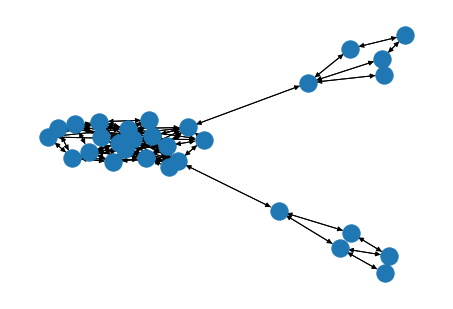

In [12]:
g = torch_geometric.utils.to_networkx(data, to_undirected=False)
nx.draw(g)

In [8]:
data.num_node_features
data.num_classes = len(np.unique(labels))
data.y = torch.LongTensor(labels)

In [9]:
n = data.num_nodes
data.train_mask, data.val_mask, data.test_mask = torch.zeros(n, dtype=torch.uint8), torch.zeros(n, dtype=torch.uint8), torch.zeros(n, dtype=torch.uint8)

In [10]:
from sklearn.model_selection import train_test_split

train_ids, test_ids = train_test_split(range(n), test_size=0.2, random_state=42, shuffle=True)
train_ids, val_ids = train_test_split(train_ids, test_size=0.15, random_state=42, shuffle=True)

data.train_mask[train_ids] = 1
data.val_mask[val_ids] = 1
data.test_mask[test_ids] = 1

In [11]:
len(data.y[data.val_mask])

/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_18451/2781205052.py:1: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  len(data.y[data.val_mask])


360

In [12]:
nodes_sub, edge_index_sub, new_node_idx, edge_mask = k_hop_subgraph(32, 2, data.edge_index, relabel_nodes=True)
# nodes_sub is subset
# relabel_nodes changes edge_index indexation

In [13]:
new_node_idx

tensor([29])

In [41]:
mapping = {int(v): k for k, v in enumerate(subset)}
mapping

{1: 0, 30: 1, 31: 2, 32: 3, 33: 4, 34: 5}

In [40]:
nodes_sub

tensor([ 1, 30, 31, 32, 33, 34])

In [30]:
data.x[nodes_sub]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [26]:
#relabel_nodes is False
edge_index_sub

tensor([[ 1, 30, 30, 30, 31, 31, 31, 31, 32, 32, 33, 33, 34, 34],
        [31, 31, 33, 34,  1, 30, 32, 34, 31, 33, 30, 32, 30, 31]])

In [31]:
#relabel_nodes is True
edge_index_sub

tensor([[0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5],
        [2, 2, 4, 5, 0, 1, 3, 5, 2, 4, 1, 3, 1, 2]])

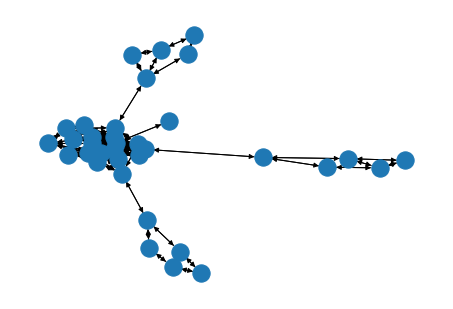

In [32]:
graph = to_networkx(data)
nx.draw(graph)

[32, 1, 33, 34, 30, 31]
[(32, 31), (32, 33), (1, 31), (33, 30), (33, 32), (34, 30), (34, 31), (30, 31), (30, 33), (30, 34), (31, 1), (31, 30), (31, 32), (31, 34)]


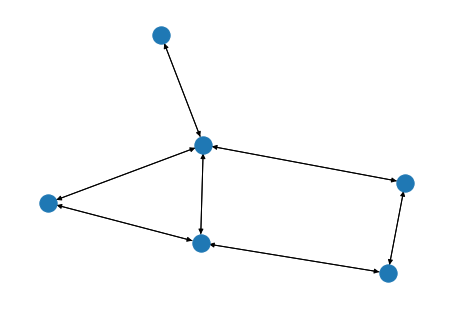

In [37]:
subset = nodes_sub
subgraph = graph.subgraph(subset.tolist())
nx.draw(subgraph)
print(subgraph.nodes())
print(subgraph.edges())

[0, 1, 2, 3, 4, 5]
[(0, 2), (1, 2), (1, 4), (1, 5), (2, 0), (2, 1), (2, 3), (2, 5), (3, 2), (3, 4), (4, 1), (4, 3), (5, 1), (5, 2)]


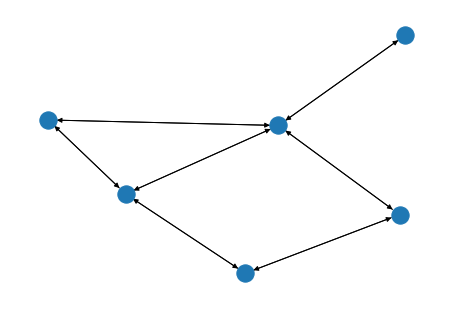

In [39]:
data_sub = Data(x=nodes_sub, edge_index=edge_index_sub)
subgraph = to_networkx(data_sub)
nx.draw(subgraph)
print(subgraph.nodes())
print(subgraph.edges())

In [13]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.num_layers = 2
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, data.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR

n_epochs = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
#scheduler = ReduceLROnPlateau(optimizer, 'min')
#scheduler = ExponentialLR(optimizer, gamma=0.99)
scheduler = StepLR(optimizer, step_size=100, gamma=0.99)

val_err = []
train_err = []
        

model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
    
    if epoch%10==0:
        val_err.append(val_loss.item())
        train_err.append(loss.item())
        
        
    loss.backward()
    optimizer.step()
    scheduler.step()
    #scheduler.step(val_loss)

/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_18451/2399002929.py:24: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_18451/2399002929.py:25: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
/Users/kenzaamara/.conda/envs/Explain/lib/python3.8/site-packages/torch/autograd/__init__.py:154: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  Variable._execution_engine.run_backward(


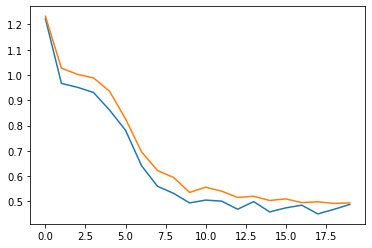

In [15]:
plt.plot(range(n_epochs//10), val_err)
plt.plot(range(n_epochs//10), train_err)

In [16]:
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.9317


/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_18451/1796556738.py:3: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()


In [17]:
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
acc = int(correct) / int(data.train_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.9098


/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_18451/3035444030.py:2: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()


In [56]:
edge_mask[indices] = torch.FloatTensor([1]*num_top_edges)
explainer.visualize_subgraph(node_idx, data.edge_index, edge_mask, y = data.y, threshold=0.99)

NameError: name 'num_top_edges' is not defined

In [18]:
def get_explanation(data, edge_mask, num_top_edges = 6, is_hard_mask = False):
    #values,indices = edge_mask.topk(num_top_edges)
    if is_hard_mask:
        explanation = data.edge_index[:,np.where(edge_mask==1)[0]]
    else:
        indices = (-edge_mask).argsort()[:num_top_edges]
        explanation = data.edge_index[:,indices]

    G_expl = nx.Graph()
    G_expl.add_nodes_from(np.unique(explanation))

    for i, (u, v) in enumerate(explanation.t().tolist()):
        G_expl.add_edge(u, v)
        
    return(G_expl)

In [19]:
def get_ground_truth_ba_shapes(node):
    base = [0, 1, 2, 3, 4]
    ground_truth = []
    offset = node % 5
    ground_truth = [node - offset + val for val in base]
    start = ground_truth[0]
    graph, role = house(start, role_start=1)
    return graph, role

In [20]:
def scores(G1, G2):
    g_int = nx.intersection(G1, G2)
    g_int.remove_nodes_from(list(nx.isolates(g_int)))

    n_tp = g_int.number_of_edges()
    n_fp = len(G1.edges() - g_int.edges())
    n_fn = len(G2.edges() - g_int.edges())

    precision = n_tp / (n_tp + n_fp)
    recall = n_tp / (n_tp + n_fn)
    if n_tp == 0:
        f1_score = 0
    else: 
        f1_score = 2 * (precision * recall) / (precision + recall)

    ged = nx.graph_edit_distance(G1, G2)

    return recall, precision, f1_score, ged

In [21]:
def evaluate(node_idx, data, edge_mask, num_top_edges):
    G_true, role = get_ground_truth_ba_shapes(node_idx)
    # nx.draw(G_true, cmap=plt.get_cmap('viridis'), node_color=role, with_labels=True, font_weight='bold')
    G_expl = get_explanation(data, edge_mask, num_top_edges)
    plt.figure()
    nx.draw(G_expl,  with_labels=True, font_weight='bold')
    plt.show()
    plt.clf()
    return scores(G_expl, G_true)


Explain node 2000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 404.63it/s]


[0.9190733  0.22387436 0.15962179 0.22777154 0.25508648 0.21722127
 0.1990977  0.22491577 0.82102954 0.15872812 0.23777185 0.8392773
 0.19098997 0.86580026]


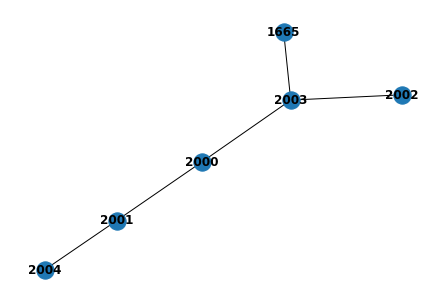

f1_score, ged 0.7272727272727272 4.0



Explain node 2001: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 466.90it/s]

[0.8265312  0.8165981  0.76868254 0.77264285 0.8793275  0.09157026
 0.8485478  0.18012127 0.8209327  0.81944466 0.14140272 0.87774646]


<Figure size 432x288 with 0 Axes>

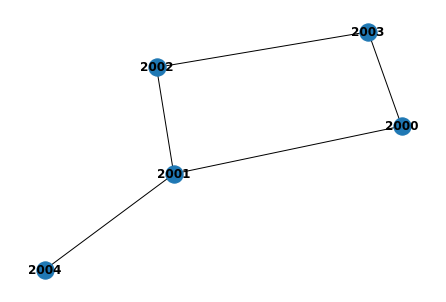

f1_score, ged 0.9090909090909091 1.0



Explain node 2002: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 393.32it/s]

[0.22985294 0.19053    0.8442345  0.88584876 0.8163918  0.36325198
 0.20691039 0.8330008  0.8390642  0.85137653 0.17031024 0.20317915
 0.82600176 0.18488875]


<Figure size 432x288 with 0 Axes>

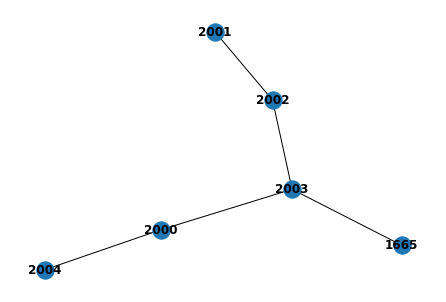

f1_score, ged 0.7272727272727272 4.0



Explain node 2003: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 470.88it/s]

[0.8460269  0.9158822  0.835577   0.2331419  0.22801633 0.08003879
 0.8557353  0.20634653 0.8131481  0.834206   0.23016438 0.8217876
 0.18014525 0.18887998 0.8519081  0.23844114 0.20455001 0.22438836
 0.25048897 0.21297036 0.18481581 0.24983527 0.23353757 0.8289273 ]


<Figure size 432x288 with 0 Axes>

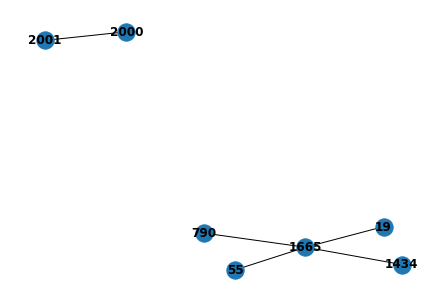

f1_score, ged 0.1818181818181818 7.0



Explain node 2004: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 515.77it/s]


[0.8085748  0.21344852 0.7658273  0.8261357  0.2125014  0.73578346
 0.14245814 0.19833483 0.13816427 0.8676365  0.8094148  0.20102157]


<Figure size 432x288 with 0 Axes>

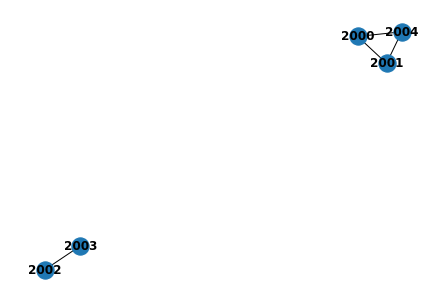

f1_score, ged 0.8 2.0



Explain node 2005: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 505.58it/s]


[0.8736717  0.19511138 0.23193435 0.8242139  0.3055969  0.8969541
 0.88255894 0.83566904 0.832698   0.19525163 0.20576079 0.83059585
 0.35631758 0.22657305]


<Figure size 432x288 with 0 Axes>

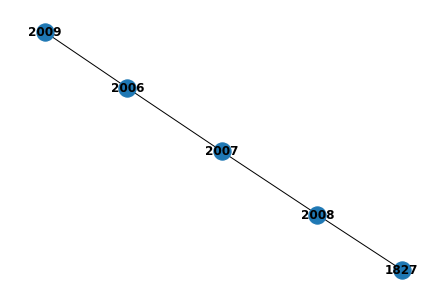

f1_score, ged 0.6 2.0



Explain node 2006: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 422.26it/s]

[0.82395035 0.8312519  0.11394876 0.14530046 0.7899034  0.7938699
 0.60433704 0.9264384  0.15327215 0.12795614 0.76873255 0.8830621 ]


<Figure size 432x288 with 0 Axes>

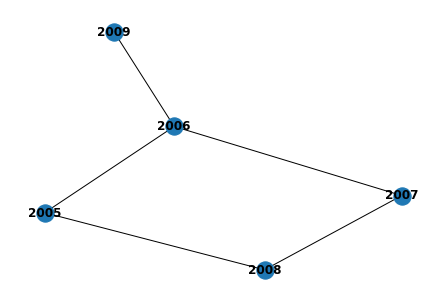

f1_score, ged 0.9090909090909091 1.0



Explain node 2007: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 365.66it/s]

[0.8165146  0.14933142 0.8658692  0.1408984  0.18171218 0.2857437
 0.1413292  0.81616336 0.22189201 0.07917061 0.87509304 0.15474196
 0.1927456  0.19451544]


<Figure size 432x288 with 0 Axes>

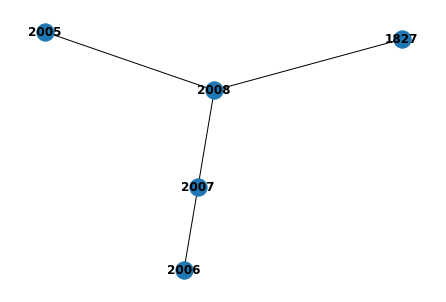

f1_score, ged 0.6 2.0



Explain node 2008: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 456.70it/s]

[0.24356388 0.25435647 0.2307983  0.84388393 0.23816241 0.822861
 0.80937403 0.88483477 0.17487748 0.19276313 0.30799186 0.8653566
 0.3306781  0.18978812 0.24102026 0.25230044 0.8191698  0.17283505
 0.26998478 0.23053013 0.20663123 0.8642807  0.25202888 0.819416  ]


<Figure size 432x288 with 0 Axes>

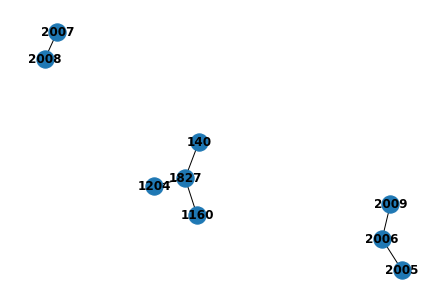

f1_score, ged 0.5 10.0



Explain node 2009: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 473.33it/s]

[0.8004724  0.87528735 0.10549399 0.83195424 0.19770995 0.12414408
 0.79472953 0.13263571 0.82662773 0.8683647  0.83778673 0.8081178 ]


<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [23]:
from torch_geometric.nn import GNNExplainer

list_node_idx = range(n_basis,n_basis+5*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

explainer = GNNExplainer(model)
for node_idx in list_node_idx:
    node_feat_mask, edge_mask = explainer.explain_node(node_idx, x = data.x, edge_index = data.edge_index)
    node_feat_mask, edge_mask = node_feat_mask.detach().numpy(), edge_mask.detach().numpy()
    print(edge_mask[np.where(edge_mask>0)[0]])
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [63]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.7026123301985372 3.413793103448276 0.6264367816091956 0.810919540229885


In [24]:
from captum._utils.common import (
    _format_additional_forward_args,
    _format_input,
    _format_output,
)
from captum._utils.gradient import (
    apply_gradient_requirements,
    compute_layer_gradients_and_eval,
    undo_gradient_requirements,
)
from captum._utils.typing import TargetType
from captum.attr import Saliency, IntegratedGradients, LayerGradCam

In [25]:
def mask_to_directed(edge_mask, edge_index):
    directed_edge_mask = edge_mask.copy()
    for i, (u, v) in enumerate(edge_index.t().tolist()):
        if u > v:
            directed_edge_mask[i]=0
    return directed_edge_mask

In [26]:
def model_forward(edge_mask, model, node_idx, x, edge_index):
    out = model(x, edge_index, edge_mask)
    return out[[node_idx]]

def model_forward_node(x, model, edge_index, node_idx):
    out = model(x, edge_index)
    return out[[node_idx]]

def node_attr_to_edge(edge_index, node_mask):
    edge_mask = np.zeros(edge_index.shape[1])
    edge_mask += node_mask[edge_index[0].cpu().numpy()]
    edge_mask += node_mask[edge_index[1].cpu().numpy()]
    return edge_mask

In [27]:
def explain_sa(model, node_idx, x, edge_index, target, include_edges=None):
    saliency = Saliency(model_forward)
    input_mask = torch.ones(edge_index.shape[1]).requires_grad_(True).to(device)
    saliency_mask = saliency.attribute(input_mask, target=target,
                                       additional_forward_args=(model, node_idx, x, edge_index), abs=False)

    edge_mask = saliency_mask.cpu().numpy()
    return edge_mask

def explain_sa_node(model, node_idx, x, edge_index, target, include_edges=None):
    saliency = Saliency(model_forward_node)
    input_mask = x.clone().requires_grad_(True).to(device)
    saliency_mask = saliency.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx),
                                       abs=False)

    node_attr = saliency_mask.cpu().numpy().sum(axis=1)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

[0.12149023 0.12149023 0.12149023 0.12149023 0.12149023 0.12149023
 0.12149023 0.12149023 0.12149023 0.12149023 0.44292311 0.30224955
 0.44292311 0.30224955]


Explain node 2038:  20%|█████████████████████▌                                                                                      | 20/100 [19:41<1:18:44, 59.06s/it]


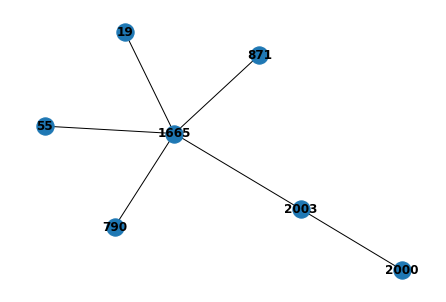

tensor([[1665, 2000,  790,  871,   55,   19],
        [2003, 2003, 1665, 1665, 1665, 1665]])
f1_score, ged 0.16666666666666666 6.0
[0.3718431  0.19479473 0.3718431  0.19479473]


<Figure size 432x288 with 0 Axes>

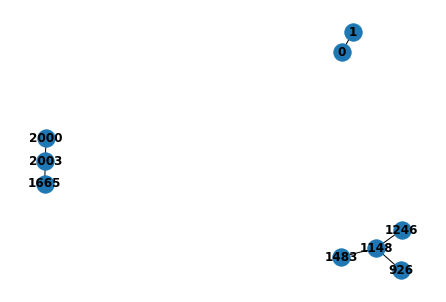

tensor([[1665, 2000,    0, 1148, 1148, 1148],
        [2003, 2003,    1, 1483, 1246,  926]])
f1_score, ged 0.16666666666666666 10.0
[]


<Figure size 432x288 with 0 Axes>

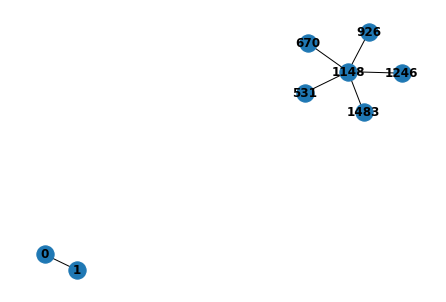

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

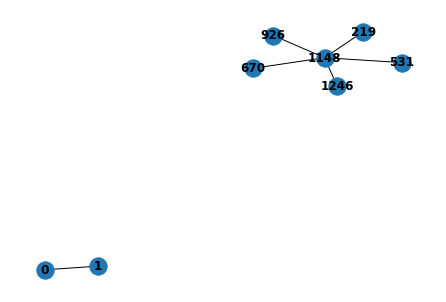

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

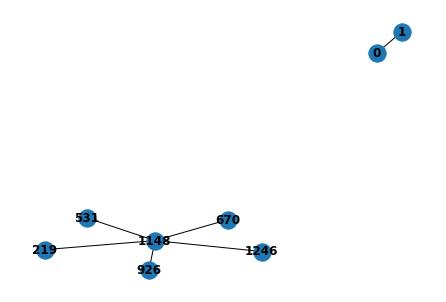

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[0.12149023 0.12149023 0.12149023 0.12149023 0.12149023 0.12149023
 0.12149023 0.12149023 0.12149023 0.12149023 0.44292311 0.30224955
 0.44292311 0.30224955]


<Figure size 432x288 with 0 Axes>

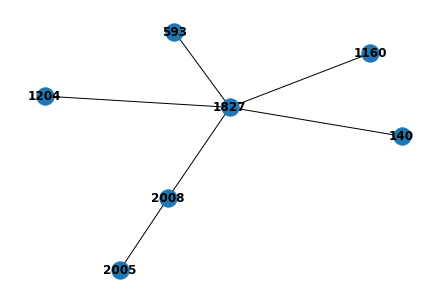

tensor([[1827, 2005, 1160,  140,  593, 1204],
        [2008, 2008, 1827, 1827, 1827, 1827]])
f1_score, ged 0.16666666666666666 6.0
[0.3718431  0.19479473 0.3718431  0.19479473]


<Figure size 432x288 with 0 Axes>

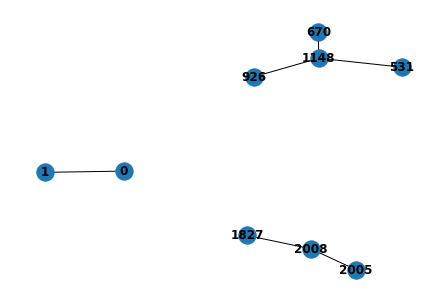

tensor([[1827, 2005,    0, 1148, 1148, 1148],
        [2008, 2008,    1,  926,  670,  531]])
f1_score, ged 0.16666666666666666 10.0
[]


<Figure size 432x288 with 0 Axes>

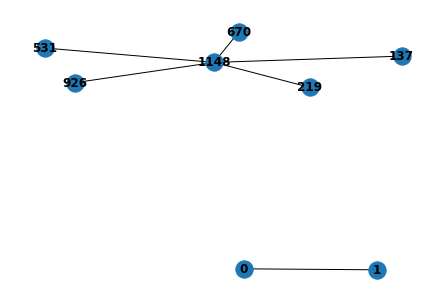

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1,  926,  670,  531,  219,  137]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

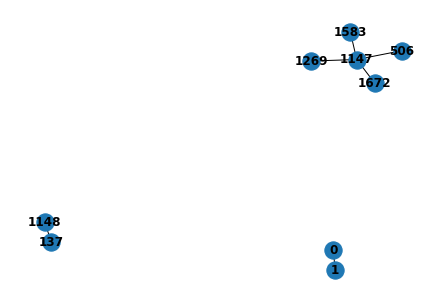

tensor([[   0, 1148, 1147, 1147, 1147, 1147],
        [   1,  137, 1672, 1583, 1269,  506]])
f1_score, ged 0 10.0
[]


<Figure size 432x288 with 0 Axes>

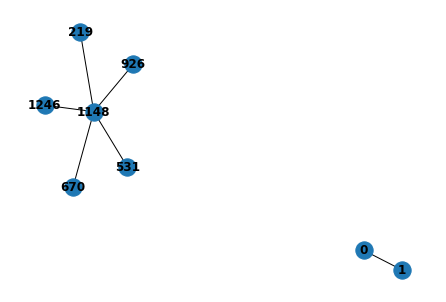

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[0.3718431  0.19479473 0.3718431  0.19479473]


<Figure size 432x288 with 0 Axes>

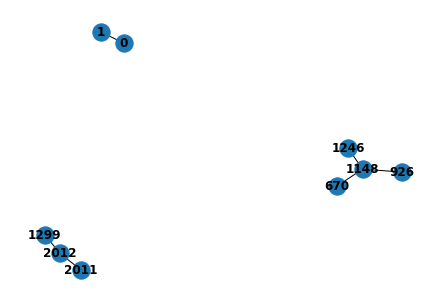

tensor([[1299, 2011,    0, 1148, 1148, 1148],
        [2012, 2012,    1, 1246,  926,  670]])
f1_score, ged 0.16666666666666666 10.0
[0.12149023 0.12149023 0.12149023 0.12149023 0.12149023 0.12149023
 0.12149023 0.12149023 0.12149023 0.12149023 0.44292311 0.30224955
 0.44292311 0.30224955]


<Figure size 432x288 with 0 Axes>

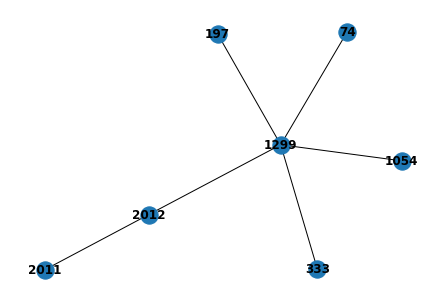

tensor([[1299, 2011, 1054,  197,  333,   74],
        [2012, 2012, 1299, 1299, 1299, 1299]])
f1_score, ged 0.16666666666666666 6.0
[]


<Figure size 432x288 with 0 Axes>

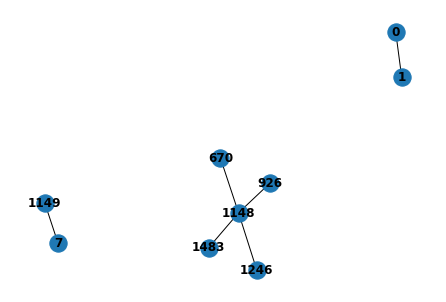

tensor([[   0, 1149, 1148, 1148, 1148, 1148],
        [   1,    7, 1483, 1246,  926,  670]])
f1_score, ged 0 10.0
[]


<Figure size 432x288 with 0 Axes>

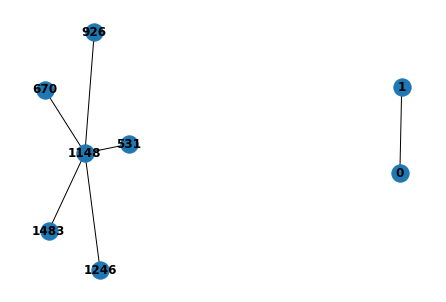

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

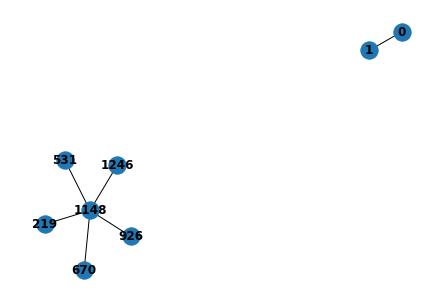

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[0.3718431  0.19479473 0.3718431  0.19479473]


<Figure size 432x288 with 0 Axes>

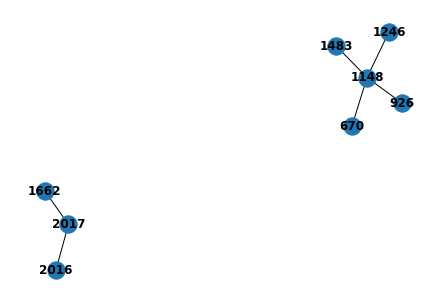

tensor([[1662, 2016, 1148, 1148, 1148, 1148],
        [2017, 2017, 1483, 1246,  926,  670]])
f1_score, ged 0.16666666666666666 9.0
[0.12149023 0.12149023 0.12149023 0.12149023 0.12149023 0.12149023
 0.12149023 0.12149023 0.12149023 0.12149023 0.44292311 0.30224955
 0.44292311 0.30224955]


<Figure size 432x288 with 0 Axes>

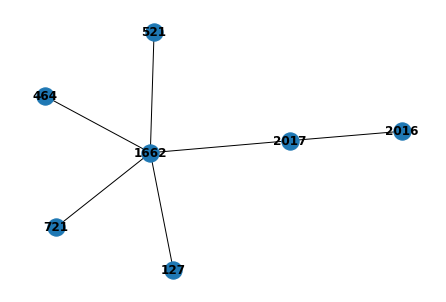

tensor([[1662, 2016,  127,  721,  521,  464],
        [2017, 2017, 1662, 1662, 1662, 1662]])
f1_score, ged 0.16666666666666666 6.0
[]


<Figure size 432x288 with 0 Axes>

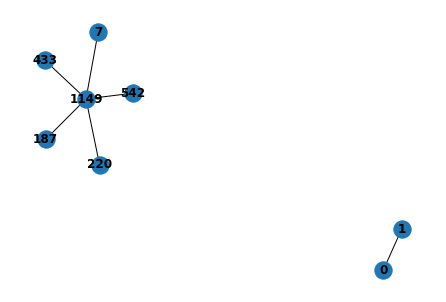

tensor([[   0, 1149, 1149, 1149, 1149, 1149],
        [   1,  542,  433,  220,  187,    7]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

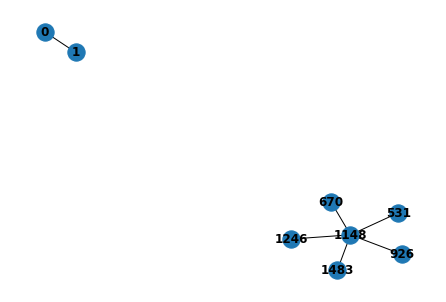

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

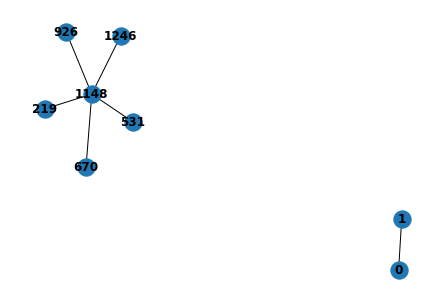

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[0.49985737 0.03925937 0.49985737 0.03925937]


<Figure size 432x288 with 0 Axes>

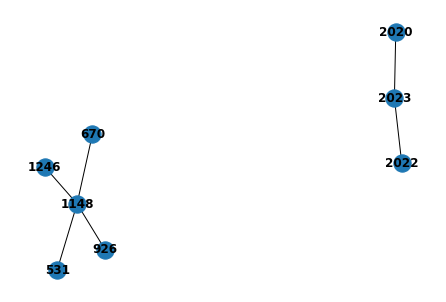

tensor([[2020, 2022, 1148, 1148, 1148, 1148],
        [2023, 2023, 1246,  926,  670,  531]])
f1_score, ged 0.3333333333333333 9.0
[0.06171907 0.02807346 0.03380493 0.05345029 0.03299023 0.05345029
 0.03380493 0.04780739 0.03380493 0.02807346 0.03299023 0.02807346
 0.02807346 0.02807346 0.03380493 0.03299023 0.03380493 0.03299023
 0.02807346 0.02807346 0.02807346 0.02807346 0.02807346 0.02807346
 0.02807346 0.02807346 0.02807346 0.02807346 0.02807346 0.02807346
 0.02807346 0.02807346 0.02807346 0.02807346 0.02807346 0.02807346
 0.02807346 0.02807346 0.02807346 0.02807346 0.02807346 0.02807346
 0.02807346 0.02807346 0.02807346 0.03299023 0.02807346 0.03380493
 0.03380493 0.03380493 0.03380493 0.03380493 0.03380493 0.03380493
 0.03380493 0.03380493 0.03380493 0.03380493 0.03380493 0.03380493
 0.03380493 0.03380493 0.03380493 0.03380493 0.03380493 0.02807346
 0.03380493 0.03299023 0.03299023 0.03299023 0.03299023 0.03299023
 0.03299023 0.03299023 0.03299023 0.03299023 0.03299023 0.03299023

<Figure size 432x288 with 0 Axes>

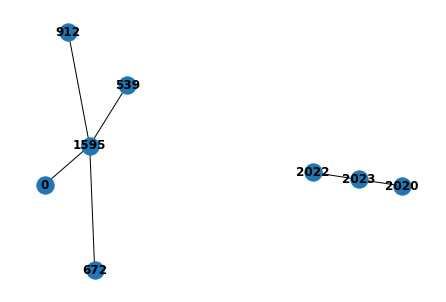

tensor([[2020,  912,  672,    0,  539, 2022],
        [2023, 1595, 1595, 1595, 1595, 2023]])
f1_score, ged 0.3333333333333333 9.0
[]


<Figure size 432x288 with 0 Axes>

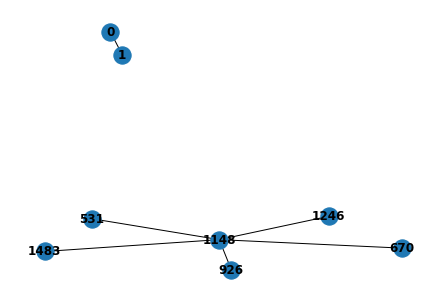

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

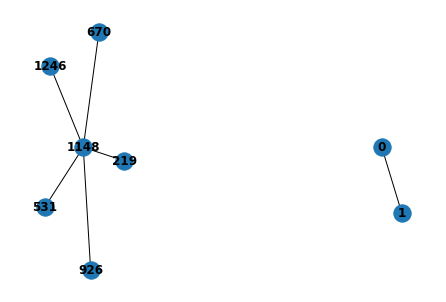

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

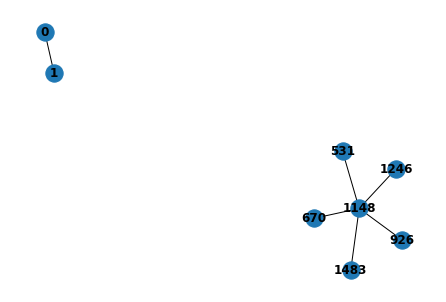

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[0.3718431  0.19479473 0.3718431  0.19479473]


<Figure size 432x288 with 0 Axes>

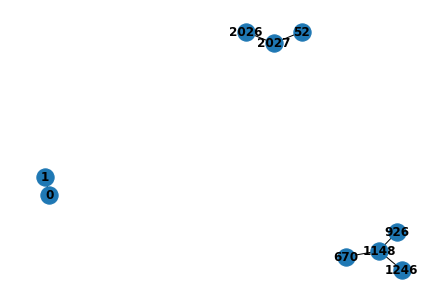

tensor([[  52, 2026,    0, 1148, 1148, 1148],
        [2027, 2027,    1, 1246,  926,  670]])
f1_score, ged 0.16666666666666666 10.0
[0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.38900179 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595
 0.05046595 0.05046595 0.05046595 0.05046595 0.05046595 0.050465

<Figure size 432x288 with 0 Axes>

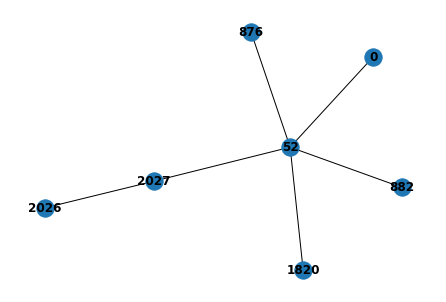

tensor([[  52, 2026,   52,   52,    0,   52],
        [2027, 2027, 1820,  876,   52,  882]])
f1_score, ged 0.16666666666666666 6.0
[0.01317584 0.6426307  0.74559513 0.51727328 0.6426307  0.38622118
 0.46784016 0.01317584 0.38622118 0.48918561 0.74559513 0.48918561
 0.51727328 0.46784016]


<Figure size 432x288 with 0 Axes>

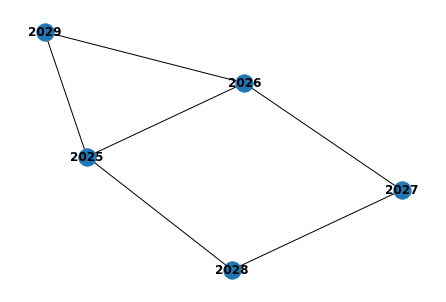

tensor([[2025, 2025, 2025, 2027, 2026, 2026],
        [2028, 2026, 2029, 2028, 2029, 2027]])
f1_score, ged 1.0 0.0
[]


<Figure size 432x288 with 0 Axes>

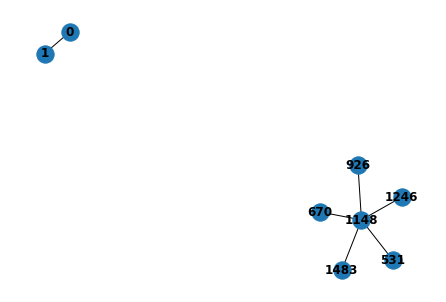

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

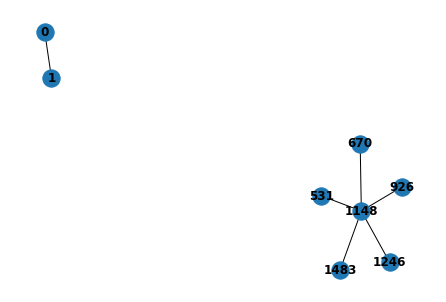

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[0.0283384  0.0148225  0.05768001 0.05768001 0.0283384  0.0283384
 0.0283384  0.0283384  0.0431609  0.0283384  0.0283384  0.0283384
 0.0283384  0.0283384  0.0283384  0.0283384  0.0283384  0.0283384
 0.0283384  0.0283384  0.0283384  0.0283384  0.0283384  0.0283384
 0.0283384  0.0283384  0.0283384  0.0283384  0.0283384  0.0283384
 0.0283384  0.0148225  0.0283384  0.0148225  0.05768001 0.0283384
 0.0148225  0.03412396 0.0283384  0.0148225  0.0431609  0.0148225
 0.0148225  0.0148225  0.0148225  0.0148225  0.0148225  0.0148225
 0.0148225  0.0148225  0.0148225  0.0148225  0.0148225  0.0148225
 0.0148225  0.0148225  0.0148225  0.0148225  0.0148225  0.0148225
 0.0148225  0.0148225  0.0148225  0.0148225  0.0148225  0.0148225
 0.0148225  0.0148225  0.0148225  0.0148225  0.0148225  0.0148225
 0.0148225  0.0148225  0.0148225  0.0148225  0.0148225  0.0148225
 0.0148225  0.0148225  0.0148

<Figure size 432x288 with 0 Axes>

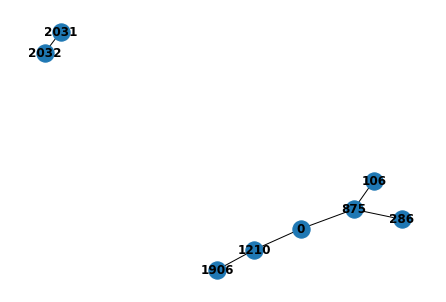

tensor([[2031,    0, 1210,  286,    0,  106],
        [2032,  875, 1906,  875, 1210,  875]])
f1_score, ged 0.16666666666666666 7.0
[0.49985737 0.49985737 0.03925937 0.03925937]


<Figure size 432x288 with 0 Axes>

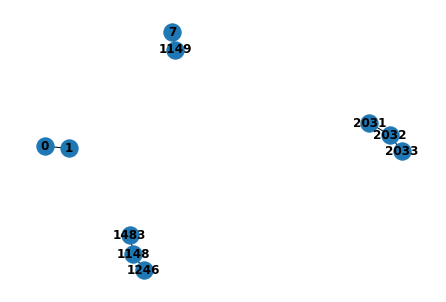

tensor([[2031, 2032,    0, 1149, 1148, 1148],
        [2032, 2033,    1,    7, 1483, 1246]])
f1_score, ged 0.3333333333333333 11.0
[]


<Figure size 432x288 with 0 Axes>

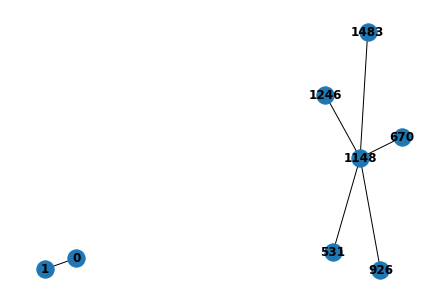

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

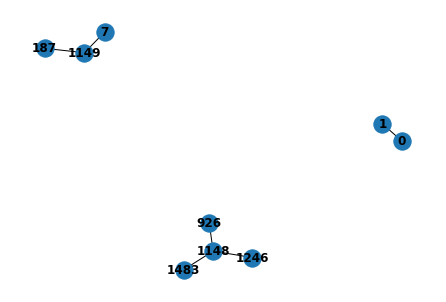

tensor([[   0, 1149, 1149, 1148, 1148, 1148],
        [   1,  187,    7, 1483, 1246,  926]])
f1_score, ged 0 10.0
[]


<Figure size 432x288 with 0 Axes>

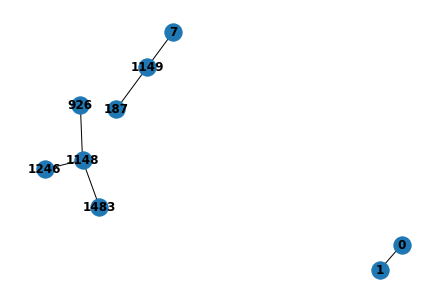

tensor([[   0, 1149, 1149, 1148, 1148, 1148],
        [   1,  187,    7, 1483, 1246,  926]])
f1_score, ged 0 10.0
[0.10033855 0.10033855 0.10033855 0.10033855 0.10033855 0.10033855
 0.10033855 0.10033855 0.10033855 0.10033855 0.10033855 0.10033855
 0.10033855 0.57628608 0.10033855 0.10033855 0.10033855 1.16342726
 1.11492842 1.16342726 1.16342726 0.90339622 0.95189506 0.90339622
 0.85489738 1.11492842 0.85489738 0.57628608 1.16342726 0.95189506]


<Figure size 432x288 with 0 Axes>

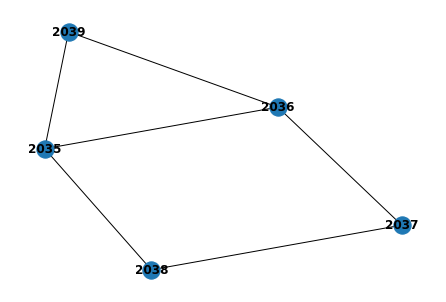

tensor([[2035, 2035, 2035, 2036, 2036, 2037],
        [2036, 2039, 2038, 2039, 2037, 2038]])
f1_score, ged 1.0 0.0
[0.10033855 0.10033855 0.10033855 0.10033855 0.10033855 0.10033855
 0.10033855 0.10033855 0.10033855 0.10033855 0.10033855 0.10033855
 0.10033855 0.57628608 0.10033855 0.10033855 0.10033855 1.16342726
 0.90339622 0.95189506 1.16342726 1.11492842 1.16342726 1.11492842
 0.85489738 0.90339622 0.85489738 0.57628608 0.95189506 1.16342726]


<Figure size 432x288 with 0 Axes>

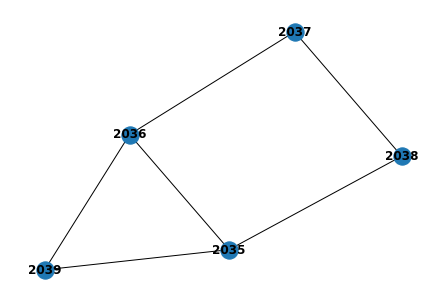

tensor([[2036, 2035, 2036, 2035, 2035, 2037],
        [2039, 2036, 2037, 2039, 2038, 2038]])
f1_score, ged 1.0 0.0
[]


<Figure size 432x288 with 0 Axes>

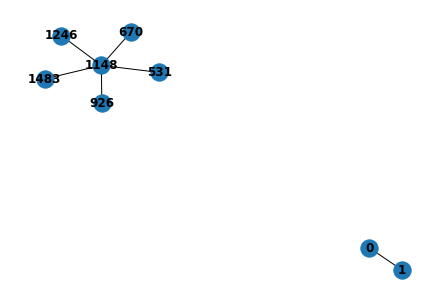

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

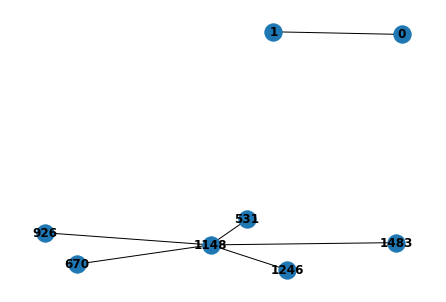

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

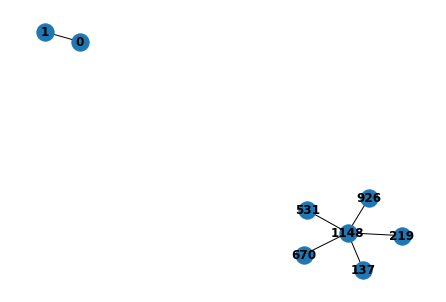

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1,  926,  670,  531,  219,  137]])
f1_score, ged 0 9.0
[0.00906867 0.01131443 0.01241778 0.00906867 0.00906867 0.00906867
 0.01131443 0.00906867 0.01131443 0.01241778 0.01131443 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.02038309 0.00906867 0.00906867 0.02148645 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867 0.00906867
 0.00906867 0.00

<Figure size 432x288 with 0 Axes>

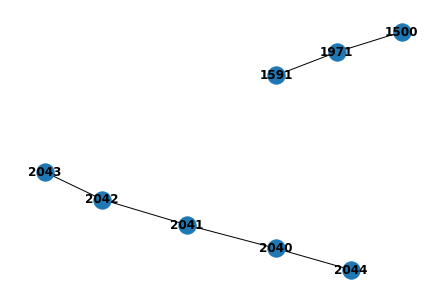

tensor([[2041, 2042, 2040, 2040, 1500, 1591],
        [2042, 2043, 2041, 2044, 1971, 1971]])
f1_score, ged 0.6666666666666666 7.0
[0.04492909 0.04492909 0.56909777 0.02104423 0.56909777 0.14665738
 0.14665738 0.02104423]


<Figure size 432x288 with 0 Axes>

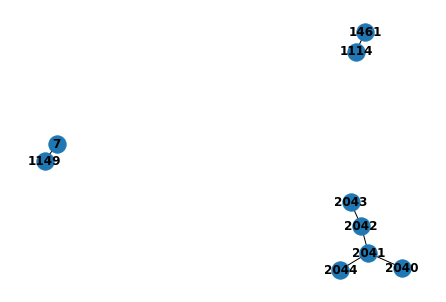

tensor([[2041, 2042, 2040, 2041, 1114, 1149],
        [2042, 2043, 2041, 2044, 1461,    7]])
f1_score, ged 0.6666666666666666 8.0
[]


<Figure size 432x288 with 0 Axes>

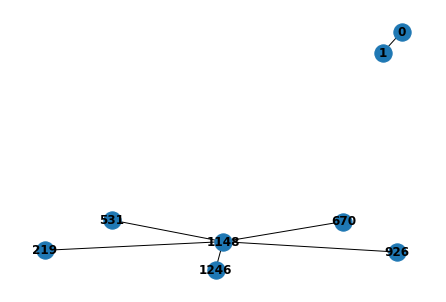

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

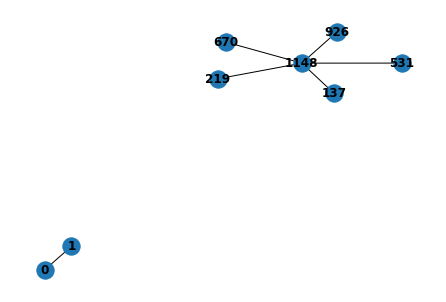

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1,  926,  670,  531,  219,  137]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

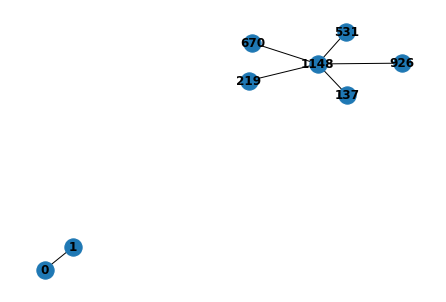

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1,  926,  670,  531,  219,  137]])
f1_score, ged 0 9.0
[0.67361777 0.67361777 1.50278628 1.3348158  1.62431377 1.50278628
 1.4610613  1.69265968 1.4610613  1.29309082 1.3348158  1.29309082
 1.62431377 1.69265968]


<Figure size 432x288 with 0 Axes>

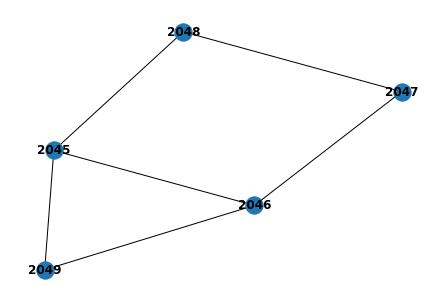

tensor([[2046, 2045, 2045, 2046, 2045, 2047],
        [2049, 2049, 2046, 2047, 2048, 2048]])
f1_score, ged 1.0 0.0
[0.04757698 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698
 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698
 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698
 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698
 0.04757698 0.04757698 0.04757698 0.04757698 0.49635072 0.04757698
 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698
 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698
 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698
 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698 0.04757698
 0.04757698 0.49635072 1.16402626 0.84323466 1.02813816 1.16402626
 1.14669412 1.29461694 1.14669412 0.82590252 0.84323466 0.82590252
 1.02813816 1.29461694]


<Figure size 432x288 with 0 Axes>

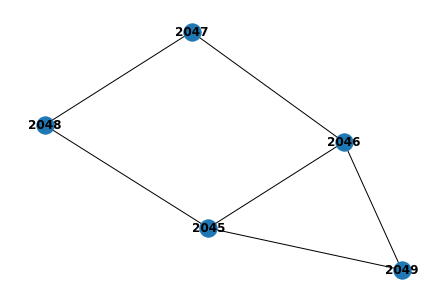

tensor([[2046, 2045, 2046, 2045, 2045, 2047],
        [2049, 2046, 2047, 2049, 2048, 2048]])
f1_score, ged 1.0 0.0
[]


<Figure size 432x288 with 0 Axes>

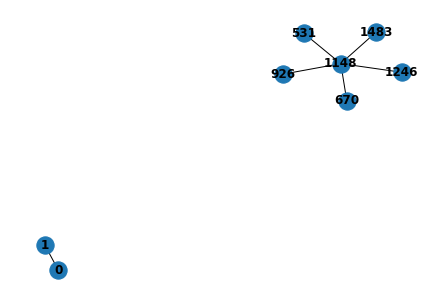

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

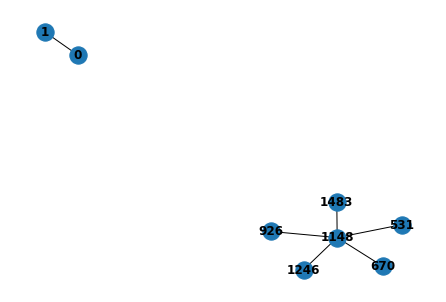

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

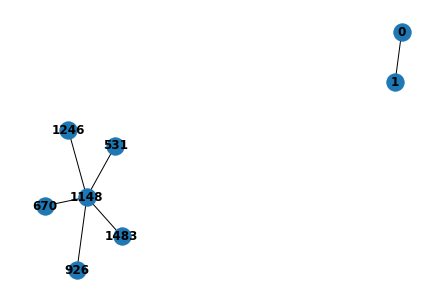

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[0.11123801 0.11123801 0.11123801 0.11123801 0.11123801 0.11123801
 0.11123801 0.11123801 0.11123801 0.11123801 0.11123801 0.58318091
 0.11123801 1.15363824 1.10554743 1.15363824 1.15363824 0.89579499
 0.9438858  0.89579499 0.84770417 1.10554743 0.84770417 0.58318091
 1.15363824 0.9438858 ]


<Figure size 432x288 with 0 Axes>

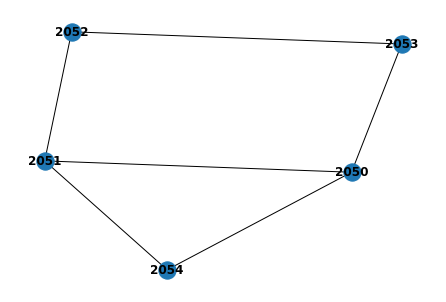

tensor([[2050, 2050, 2050, 2051, 2051, 2052],
        [2054, 2051, 2053, 2054, 2052, 2053]])
f1_score, ged 1.0 0.0
[0.11123801 0.11123801 0.11123801 0.11123801 0.11123801 0.11123801
 0.11123801 0.11123801 0.11123801 0.11123801 0.11123801 0.58318091
 0.11123801 1.15363824 0.89579499 0.9438858  1.15363824 1.10554743
 1.15363824 1.10554743 0.84770417 0.89579499 0.84770417 0.58318091
 0.9438858  1.15363824]


<Figure size 432x288 with 0 Axes>

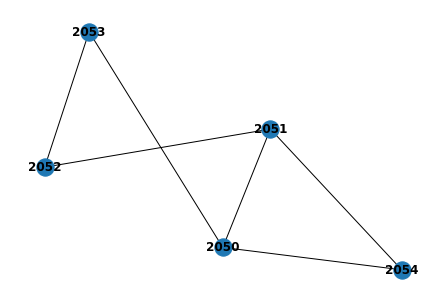

tensor([[2051, 2050, 2051, 2050, 2050, 2052],
        [2054, 2051, 2052, 2054, 2053, 2053]])
f1_score, ged 1.0 0.0
[]


<Figure size 432x288 with 0 Axes>

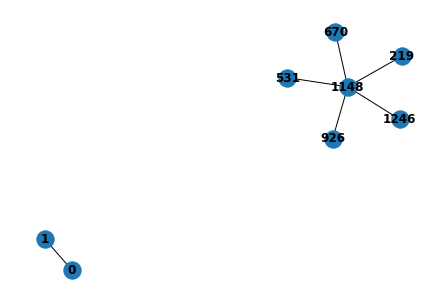

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

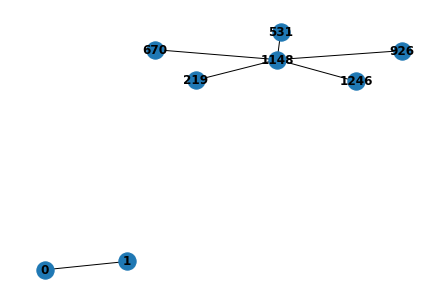

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

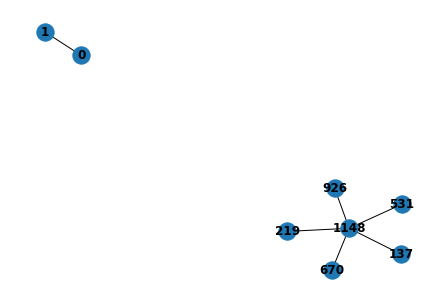

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1,  926,  670,  531,  219,  137]])
f1_score, ged 0 9.0
[0.10535829 0.10535829 0.10535829 0.10535829 0.10535829 0.10535829
 0.10535829 0.10535829 0.10535829 0.10535829 0.10535829 0.10535829
 0.57947056 0.10535829 0.10535829 1.15894109 1.11062923 1.15894109
 1.15894109 0.89991269 0.94822454 0.89991269 0.85160083 1.11062923
 0.85160083 0.57947056 1.15894109 0.94822454]


<Figure size 432x288 with 0 Axes>

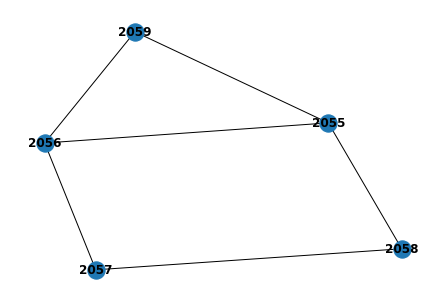

tensor([[2055, 2055, 2055, 2056, 2056, 2057],
        [2056, 2059, 2058, 2059, 2057, 2058]])
f1_score, ged 1.0 0.0
[0.10535829 0.10535829 0.10535829 0.10535829 0.10535829 0.10535829
 0.10535829 0.10535829 0.10535829 0.10535829 0.10535829 0.10535829
 0.57947056 0.10535829 0.10535829 1.15894109 0.89991269 0.94822454
 1.15894109 1.11062923 1.15894109 1.11062923 0.85160083 0.89991269
 0.85160083 0.57947056 0.94822454 1.15894109]


<Figure size 432x288 with 0 Axes>

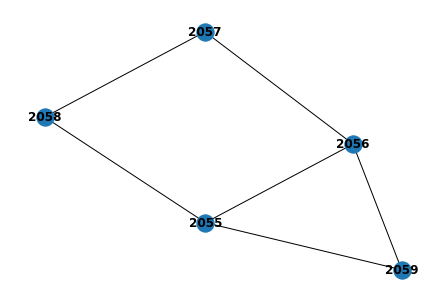

tensor([[2055, 2056, 2056, 2055, 2055, 2057],
        [2056, 2059, 2057, 2059, 2058, 2058]])
f1_score, ged 1.0 0.0
[]


<Figure size 432x288 with 0 Axes>

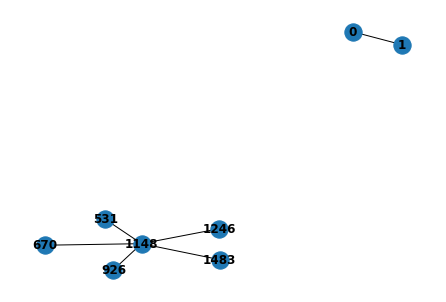

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

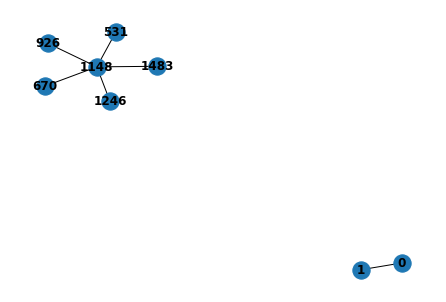

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

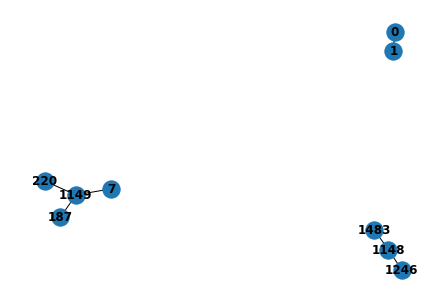

tensor([[   0, 1149, 1149, 1149, 1148, 1148],
        [   1,  220,  187,    7, 1483, 1246]])
f1_score, ged 0 10.0
[0.5388674  0.09981796 0.5388674  0.09981796]


<Figure size 432x288 with 0 Axes>

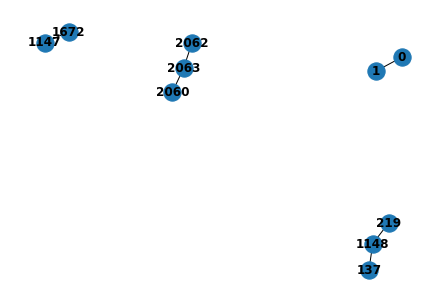

tensor([[2060, 2062,    0, 1148, 1148, 1147],
        [2063, 2063,    1,  219,  137, 1672]])
f1_score, ged 0.3333333333333333 11.0
[0.01308176 0.01033577 0.01033577 0.03832606 0.01308176 0.01308176
 0.02341753 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.05140782 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176
 0.01308176 0.01308176 0.01308176 0.01308176 0.01308176 0.0130817

<Figure size 432x288 with 0 Axes>

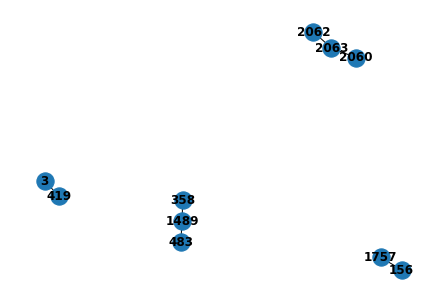

tensor([[2060, 2062,    3,  483,  358,  156],
        [2063, 2063,  419, 1489, 1489, 1757]])
f1_score, ged 0.3333333333333333 11.0
[]


<Figure size 432x288 with 0 Axes>

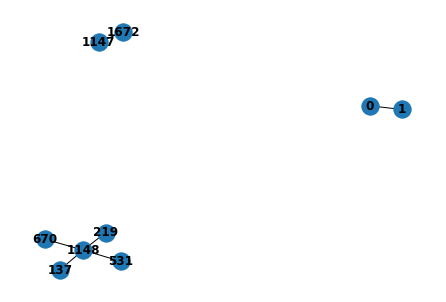

tensor([[   0, 1148, 1148, 1148, 1148, 1147],
        [   1,  670,  531,  219,  137, 1672]])
f1_score, ged 0 10.0
[]


<Figure size 432x288 with 0 Axes>

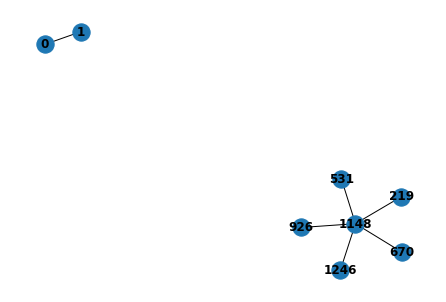

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

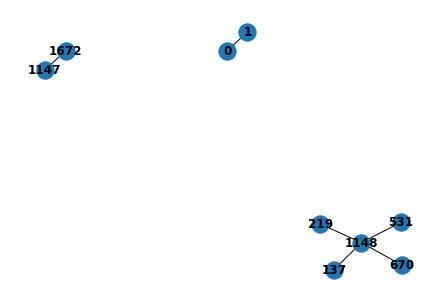

tensor([[   0, 1148, 1148, 1148, 1148, 1147],
        [   1,  670,  531,  219,  137, 1672]])
f1_score, ged 0 10.0
[0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.49239448
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717 0.04173717
 0.04173717 1.16891181 1.1515069  1.30005056 0.49239448 1.16891181
 0.84677374 1.0

<Figure size 432x288 with 0 Axes>

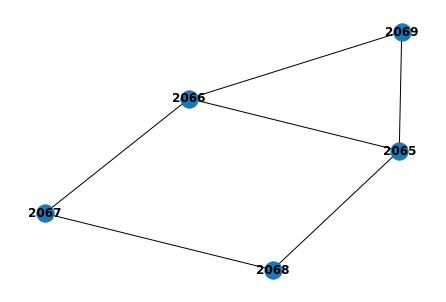

tensor([[2065, 2065, 2065, 2066, 2066, 2067],
        [2069, 2066, 2068, 2069, 2067, 2068]])
f1_score, ged 1.0 0.0
[0.89444894 1.9073174  1.81966275 2.10810441 0.89444894 1.9073174
 1.69812042 2.05867249 1.69812042 1.61046576 1.81966275 1.61046576
 2.10810441 2.05867249]


<Figure size 432x288 with 0 Axes>

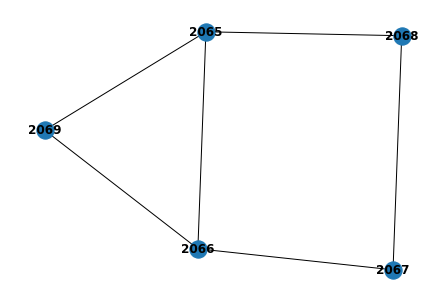

tensor([[2065, 2066, 2065, 2065, 2066, 2067],
        [2069, 2069, 2066, 2068, 2067, 2068]])
f1_score, ged 1.0 0.0
[]


<Figure size 432x288 with 0 Axes>

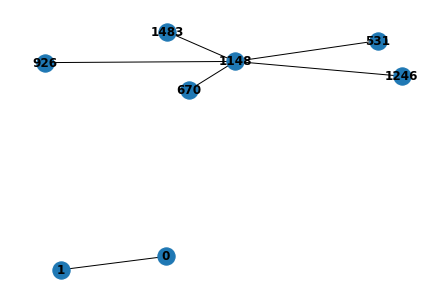

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

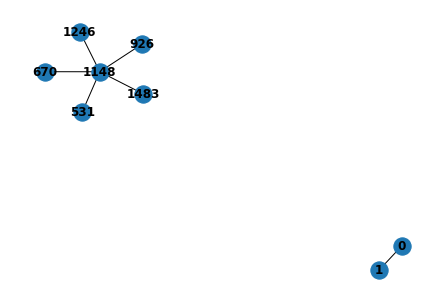

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1483, 1246,  926,  670,  531]])
f1_score, ged 0 9.0
[]


<Figure size 432x288 with 0 Axes>

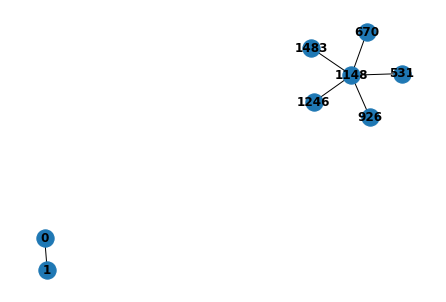

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [28]:
list_node_idx = range(n_basis,n_basis+500)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

for node_idx in list_node_idx:
    edge_mask = explain_sa_node(model, node_idx, data.x, data.edge_index, target = labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [29]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.22946859903381642 7.521739130434782 0.22946859903381642 0.22946859903381642


In [30]:
def explain_ig_node(model, node_idx, x, edge_index, target, include_edges=None):
    ig = IntegratedGradients(model_forward_node)
    input_mask = x.clone().requires_grad_(True).to(device)
    ig_mask = ig.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx),
                           internal_batch_size=input_mask.shape[0])

    node_attr = ig_mask.cpu().detach().numpy().sum(axis=1)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

[0.09808938 0.09808938 0.09808938 0.09808938 0.09808938 0.09808938
 0.09808938 0.09808938 0.09808938 0.09808938 0.36301241 0.99358245
 0.82659427 1.06039932 0.99358245 0.73708231 0.93063929 0.73708231
 0.57009413 0.36301241 0.82659427 0.57009413 1.06039932 0.93063929]


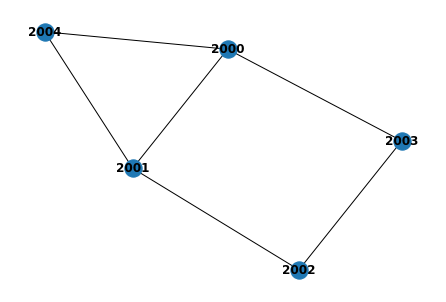

tensor([[2000, 2000, 2001, 2000, 2001, 2002],
        [2004, 2001, 2004, 2003, 2002, 2003]])
f1_score, ged 1.0 0.0
[0.29690394 1.02450091 0.72817839 0.92926728 1.02450091 0.93539022
 1.09121929 0.93539022 0.6390677  0.29690394 0.72817839 0.6390677
 0.92926728 1.09121929]


<Figure size 432x288 with 0 Axes>

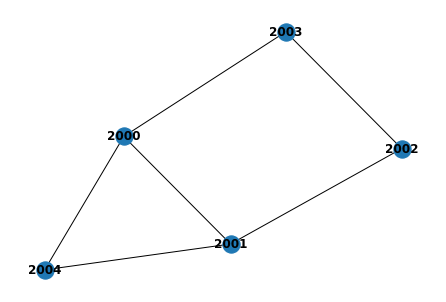

tensor([[2001, 2000, 2001, 2000, 2000, 2002],
        [2004, 2001, 2002, 2004, 2003, 2003]])
f1_score, ged 1.0 0.0
[0.00438616 0.00438616 0.00438616 0.00438616 0.00438616 0.00438616
 0.00438616 0.00438616 0.00438616 0.00438616 0.01677148 0.00710391
 0.01554696 0.0001124  0.00710391 0.01519439 0.00089305 0.01519439
 0.02363744 0.01677148 0.01554696 0.02363744 0.0001124  0.00089305]


<Figure size 432x288 with 0 Axes>

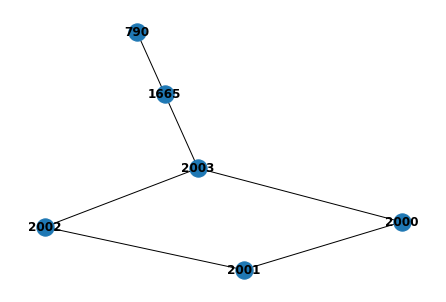

tensor([[2002, 1665, 2000, 2001, 2000,  790],
        [2003, 2003, 2003, 2002, 2001, 1665]])
f1_score, ged 0.6666666666666666 3.0
[0.00037775 0.00072897 0.00072897 0.00037775 0.00138792 0.00138792
 0.00037775 0.00037775 0.00037775 0.00072897 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775
 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775 0.00037775

<Figure size 432x288 with 0 Axes>

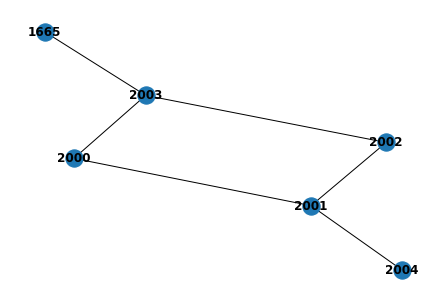

tensor([[2002, 2000, 1665, 2001, 2000, 2001],
        [2003, 2003, 2003, 2002, 2001, 2004]])
f1_score, ged 0.8333333333333334 3.0
[]


<Figure size 432x288 with 0 Axes>

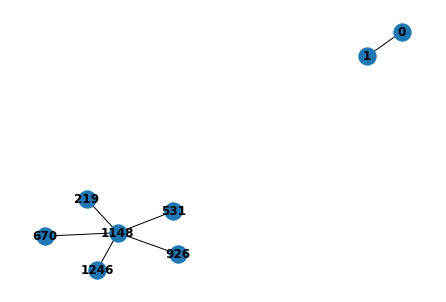

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[0.09808938 0.09808938 0.09808938 0.09808938 0.09808938 0.09808938
 0.09808938 0.09808938 0.09808938 0.09808938 0.36301241 0.99358245
 0.82659427 1.06039932 0.99358245 0.73708231 0.93063929 0.73708231
 0.57009413 0.36301241 0.82659427 0.57009413 1.06039932 0.93063929]


<Figure size 432x288 with 0 Axes>

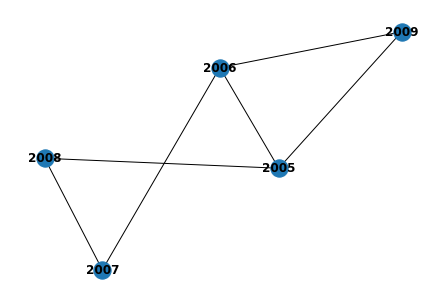

tensor([[2005, 2005, 2006, 2005, 2006, 2007],
        [2009, 2006, 2009, 2008, 2007, 2008]])
f1_score, ged 1.0 0.0
[0.29690394 1.02450091 0.72817839 0.92926728 1.02450091 0.93539022
 1.09121929 0.93539022 0.6390677  0.29690394 0.72817839 0.6390677
 0.92926728 1.09121929]


<Figure size 432x288 with 0 Axes>

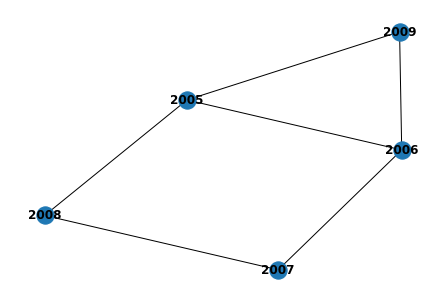

tensor([[2006, 2005, 2006, 2005, 2005, 2007],
        [2009, 2006, 2007, 2009, 2008, 2008]])
f1_score, ged 1.0 0.0
[0.00438616 0.00438616 0.00438616 0.00438616 0.00438616 0.00438616
 0.00438616 0.00438616 0.00438616 0.00438616 0.01677148 0.00710391
 0.01554696 0.0001124  0.00710391 0.01519439 0.00089305 0.01519439
 0.02363744 0.01677148 0.01554696 0.02363744 0.0001124  0.00089305]


<Figure size 432x288 with 0 Axes>

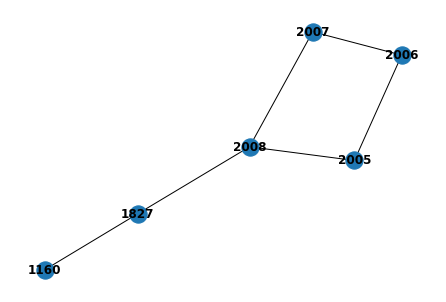

tensor([[2007, 1827, 2005, 2006, 2005, 1160],
        [2008, 2008, 2008, 2007, 2006, 1827]])
f1_score, ged 0.6666666666666666 3.0
[0.00070252 0.00114721 0.0012168  0.00070252 0.00070252 0.00070252
 0.0012168  0.0012168  0.00130082 0.00070252 0.00070252 0.00070252
 0.00070252 0.00070252 0.00070252 0.00070252 0.00070252 0.00070252
 0.00070252 0.00070252 0.00070252 0.00070252 0.00070252 0.00070252
 0.00070252 0.00070252 0.00070252 0.00070252 0.00070252 0.00070252
 0.00070252 0.00070252 0.00460162 0.00130082 0.00070252 0.0012168
 0.0012168  0.0012168  0.00130082 0.00114721 0.00130082 0.00070252
 0.00070252 0.00130082 0.00070252 0.00130082 0.00130082 0.00130082
 0.00130082 0.00130082 0.00519991 0.00114721 0.00070252 0.00070252
 0.00114721 0.00070252 0.00070252 0.00070252 0.0012168  0.00070252
 0.00070252 0.00114721 0.0012168  0.00070252 0.00070252 0.00070252
 0.00070252 0.00114721 0.00114721 0.00114721 0.00114721 0.00114721
 0.00114721 0.00114721 0.00504631 0.00070252 0.00070252 0.0012168
 

<Figure size 432x288 with 0 Axes>

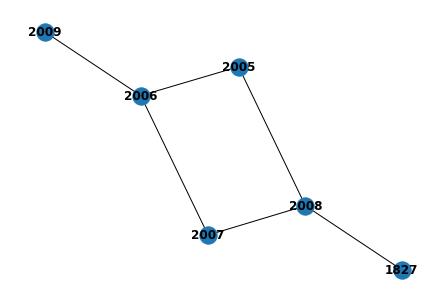

tensor([[2007, 2005, 1827, 2006, 2005, 2006],
        [2008, 2008, 2008, 2007, 2006, 2009]])
f1_score, ged 0.8333333333333334 3.0
[]


<Figure size 432x288 with 0 Axes>

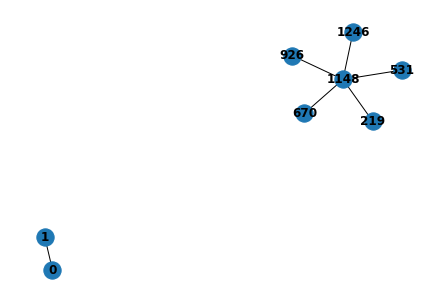

tensor([[   0, 1148, 1148, 1148, 1148, 1148],
        [   1, 1246,  926,  670,  531,  219]])
f1_score, ged 0 9.0
[0.29690394 1.02450091 0.93539022 1.09121929 1.02450091 0.72817839
 0.92926728 0.29690394 0.72817839 0.6390677  0.93539022 0.6390677
 1.09121929 0.92926728]


<Figure size 432x288 with 0 Axes>

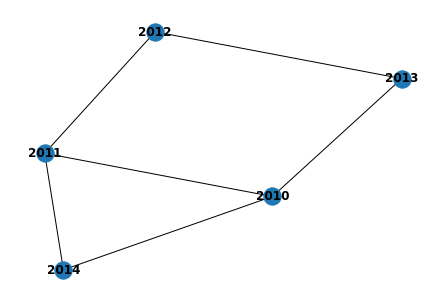

tensor([[2010, 2010, 2010, 2011, 2011, 2012],
        [2014, 2011, 2013, 2014, 2012, 2013]])
f1_score, ged 1.0 0.0
[0.09808938 0.09808938 0.09808938 0.09808938 0.09808938 0.09808938
 0.09808938 0.09808938 0.09808938 0.09808938 0.36301241 0.99358245
 0.73708231 0.93063929 0.99358245 0.82659427 1.06039932 0.36301241
 0.82659427 0.57009413 0.73708231 0.57009413 0.93063929 1.06039932]


<Figure size 432x288 with 0 Axes>

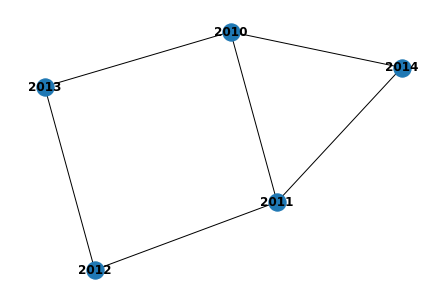

tensor([[2011, 2010, 2010, 2011, 2010, 2012],
        [2014, 2011, 2014, 2012, 2013, 2013]])
f1_score, ged 1.0 0.0
[0.00063225 0.00121067 0.00069898 0.00108285 0.00063225 0.00063225
 0.00063225 0.00069898 0.00139796 0.00063225 0.00069898 0.00063225
 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225
 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225
 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225
 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225
 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225
 0.00063225 0.0064466  0.00063225 0.00063225 0.00063225 0.00063225
 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225 0.00063225
 0.00069898 0.00108285 0.00063225 0.00069898 0.00121067 0.00069898
 0.00069898 0.00069898 0.00069898 0.00069898 0.00069898 0.00069898
 0.00069898 0.00069898 0.00069898 0.00069898 0.00069898 0.00069898
 0.00069898 0.00069898 0.00069898 0.00069898 0.00069898 0.00069898
 0.00069898 0.

<Figure size 432x288 with 0 Axes>

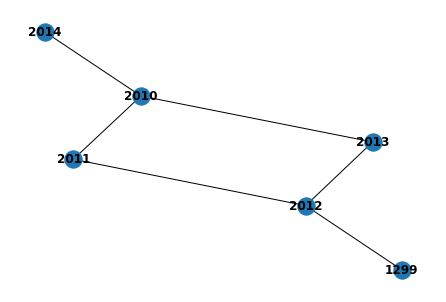

tensor([[2012, 2011, 2010, 1299, 2010, 2010],
        [2013, 2012, 2013, 2012, 2011, 2014]])
f1_score, ged 0.8333333333333334 3.0
[0.00438616 0.00438616 0.00438616 0.00438616 0.00438616 0.00438616
 0.00438616 0.00438616 0.00438616 0.00438616 0.01677148 0.00710391
 0.01519439 0.00089305 0.00710391 0.01554696 0.0001124  0.01677148
 0.01554696 0.02363744 0.01519439 0.02363744 0.00089305 0.0001124 ]


<Figure size 432x288 with 0 Axes>

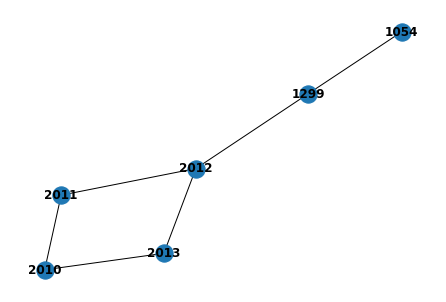

tensor([[2012, 1299, 2011, 2010, 2010, 1054],
        [2013, 2012, 2012, 2013, 2011, 1299]])
f1_score, ged 0.6666666666666666 3.0
[]


<Figure size 432x288 with 0 Axes>

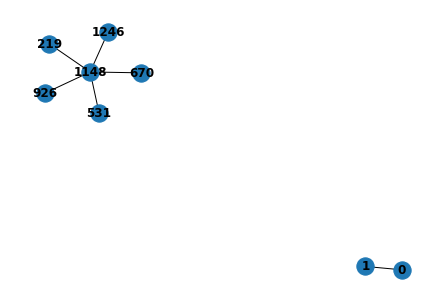

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [31]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

for node_idx in list_node_idx:
    edge_mask = explain_ig_node(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [141]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.8333333333333334 1.8571428571428572 0.8333333333333334 0.8333333333333334


In [32]:
def explain_occlusion(model, node_idx, x, edge_index, target, include_edges=None):
    depth_limit = model.num_layers + 1
    data = Data(x=x, edge_index=edge_index)
    pred_prob = model(data.x, data.edge_index)[node_idx][target].item()
    g = to_networkx(data)
    subgraph_nodes = []
    for k, v in nx.shortest_path_length(g, target=node_idx).items():
        if v < depth_limit:
            subgraph_nodes.append(k)
    subgraph = g.subgraph(subgraph_nodes)
    edge_occlusion_mask = np.ones(data.num_edges, dtype=bool)
    edge_mask = np.zeros(data.num_edges)
    edge_index_numpy = data.edge_index.cpu().numpy()
    for i in range(data.num_edges):
        if include_edges is not None and not include_edges[i].item():
            continue
        u, v = list(edge_index_numpy[:, i])
        if (u, v) in subgraph.edges():
            edge_occlusion_mask[i] = False
            prob = model(data.x, data.edge_index[:, edge_occlusion_mask])[node_idx][target].item()
            edge_mask[i] = pred_prob - prob
            edge_occlusion_mask[i] = True
    return edge_mask


[0.01549125 0.4204604  0.17534226 0.18984991 0.4204604  0.05009085
 0.34293252 0.18984991 0.4264254 ]


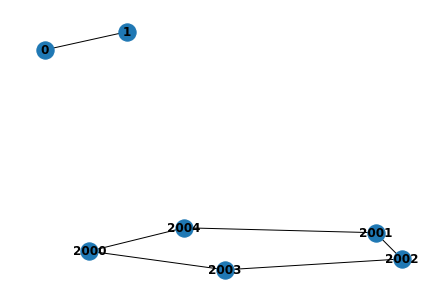

tensor([[2000, 2001, 2001, 2002, 2000,    0],
        [2004, 2004, 2002, 2003, 2003,    1]])
f1_score, ged 0.8333333333333334 4.0
[0.12051469 0.41694516 0.07163423 0.1895954  0.41694516 0.18146259
 0.07163423 0.1895954  0.10912126 0.18146259]


<Figure size 432x288 with 0 Axes>

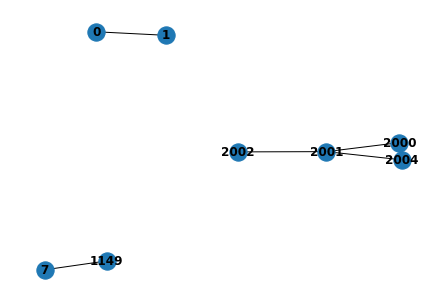

tensor([[2000, 2001, 2001, 2000,    0, 1149],
        [2004, 2004, 2002, 2001,    1,    7]])
f1_score, ged 0.6666666666666666 7.0
[0.02603137 0.00718439 0.46472955 0.23338819 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

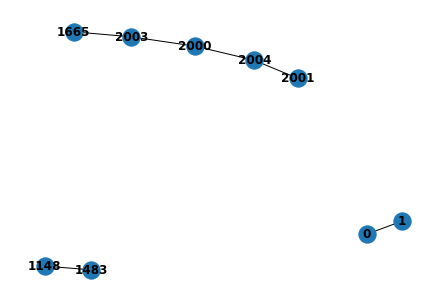

tensor([[2000, 2001, 1665, 2000,    0, 1148],
        [2004, 2004, 2003, 2003,    1, 1483]])
f1_score, ged 0.5 8.0
[1.67100430e-02 9.87148285e-03 2.71797180e-05 1.99079514e-04
 1.48463249e-03 1.48463249e-03 1.48463249e-03 6.90361261e-02
 5.58915138e-02 1.61062956e-01 9.20534134e-03 2.72258520e-02
 1.61062956e-01 5.58915138e-02 2.18153000e-04 9.20534134e-03
 2.72258520e-02 5.58915138e-02]


<Figure size 432x288 with 0 Axes>

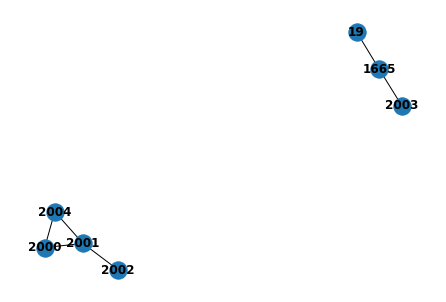

tensor([[2000, 2001, 1665, 2000, 2001,   19],
        [2004, 2004, 2003, 2001, 2002, 1665]])
f1_score, ged 0.6666666666666666 6.0
[0.03252065 0.02846277 0.49933362 0.14103723 0.2866776  0.103526
 0.02269602 0.02846277 0.14103723 0.2866776  0.14032996 0.02269602]


<Figure size 432x288 with 0 Axes>

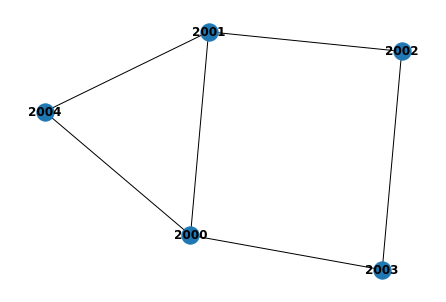

tensor([[2000, 2001, 2001, 2000, 2000, 2002],
        [2004, 2002, 2004, 2001, 2003, 2003]])
f1_score, ged 1.0 0.0
[0.01549125 0.4204604  0.17534226 0.18984991 0.4204604  0.05009085
 0.34293252 0.18984991 0.4264254 ]


<Figure size 432x288 with 0 Axes>

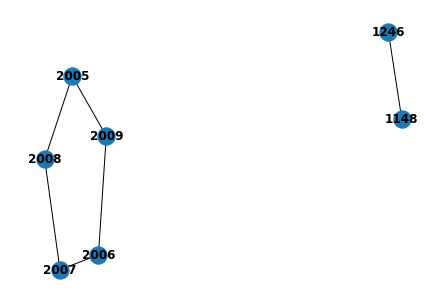

tensor([[2006, 2005, 2006, 2007, 2005, 1148],
        [2009, 2009, 2007, 2008, 2008, 1246]])
f1_score, ged 0.8333333333333334 4.0
[0.12051469 0.41694516 0.07163423 0.1895954  0.41694516 0.18146259
 0.07163423 0.1895954  0.10912126 0.18146259]


<Figure size 432x288 with 0 Axes>

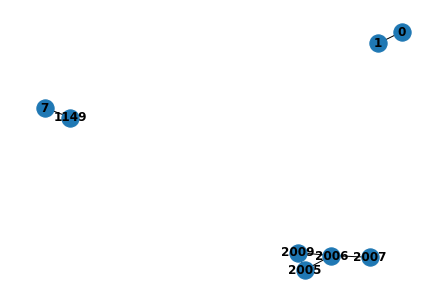

tensor([[2006, 2005, 2006, 2005,    0, 1149],
        [2009, 2009, 2007, 2006,    1,    7]])
f1_score, ged 0.6666666666666666 7.0
[0.02603137 0.00718439 0.46472955 0.23338819 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

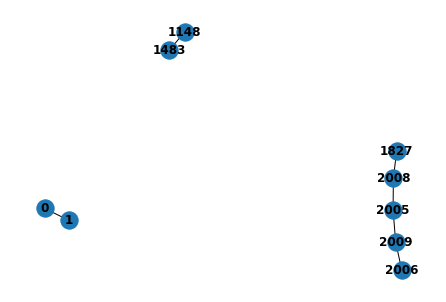

tensor([[2006, 2005, 1827, 2005,    0, 1148],
        [2009, 2009, 2008, 2008,    1, 1483]])
f1_score, ged 0.5 8.0
[0.01272047 0.00222707 0.00063252 0.00063252 0.00029409 0.00203836
 0.00135851 0.00164139 0.00164139 0.05118978 0.05576301 0.154006
 0.01026452 0.03008842 0.154006   0.05576301 0.01026452 0.03008842
 0.05576301]


<Figure size 432x288 with 0 Axes>

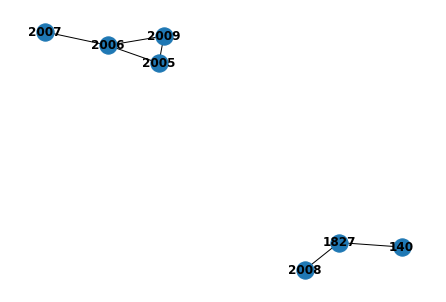

tensor([[2006, 2005, 2005, 1827, 2006,  140],
        [2009, 2009, 2006, 2008, 2007, 1827]])
f1_score, ged 0.6666666666666666 6.0
[0.03252065 0.02846277 0.49933362 0.14103723 0.2866776  0.103526
 0.02269602 0.02846277 0.14103723 0.2866776  0.14032996 0.02269602]


<Figure size 432x288 with 0 Axes>

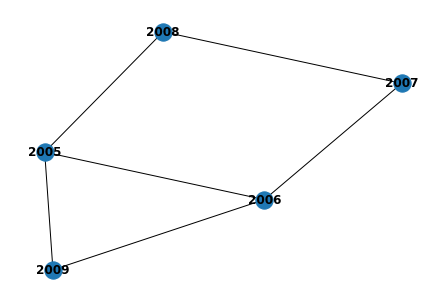

tensor([[2005, 2006, 2006, 2005, 2007, 2005],
        [2009, 2007, 2009, 2006, 2008, 2008]])
f1_score, ged 1.0 0.0
[0.07163423 0.1895954  0.41694516 0.12051469 0.41694516 0.07163423
 0.1895954  0.18146259 0.18146259 0.10912126]


<Figure size 432x288 with 0 Axes>

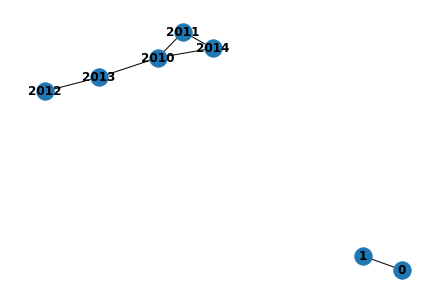

tensor([[2010, 2011, 2010, 2012, 2010,    0],
        [2014, 2014, 2013, 2013, 2011,    1]])
f1_score, ged 0.8333333333333334 4.0
[0.17534226 0.18984991 0.4204604  0.01549125 0.4204604  0.34293252
 0.18984991 0.05009085 0.4264254 ]


<Figure size 432x288 with 0 Axes>

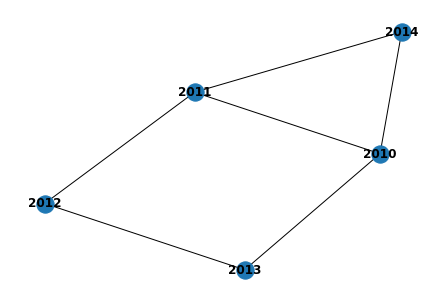

tensor([[2010, 2011, 2010, 2012, 2010, 2011],
        [2014, 2014, 2013, 2013, 2011, 2012]])
f1_score, ged 1.0 0.0
[1.03420019e-02 9.20665264e-03 2.82919407e-03 7.63416290e-04
 9.97781754e-05 1.35302544e-04 5.19633293e-04 7.36594200e-04
 1.16193295e-03 7.75719881e-02 8.66246223e-03 2.57548094e-02
 1.64820671e-01 5.59939146e-02 1.64820671e-01 8.66246223e-03
 2.57548094e-02 5.59939146e-02 5.59473038e-03 5.59939146e-02]


<Figure size 432x288 with 0 Axes>

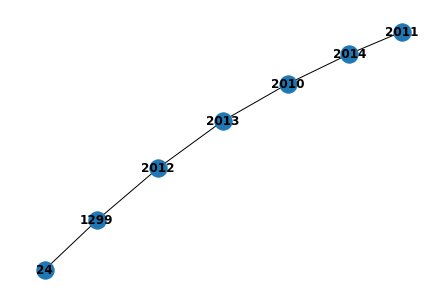

tensor([[2011, 2010, 1299, 2012, 2010,   24],
        [2014, 2014, 2012, 2013, 2013, 1299]])
f1_score, ged 0.6666666666666666 6.0
[0.02603137 0.23338819 0.46472955 0.00718439 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

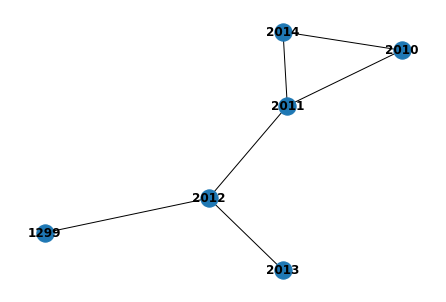

tensor([[2012, 2010, 2011, 2010, 1299, 2011],
        [2013, 2014, 2014, 2011, 2012, 2012]])
f1_score, ged 0.8333333333333334 3.0
[0.14103723 0.2866776  0.103526   0.03252065 0.02846277 0.49933362
 0.14103723 0.2866776  0.02269602 0.02846277 0.02269602 0.14032996]


<Figure size 432x288 with 0 Axes>

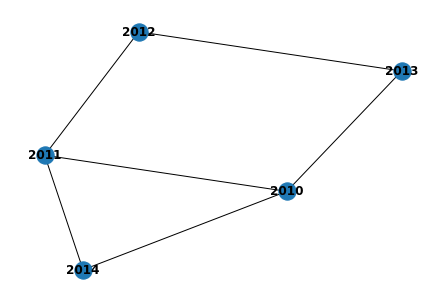

tensor([[2011, 2010, 2012, 2010, 2010, 2011],
        [2014, 2013, 2013, 2011, 2014, 2012]])
f1_score, ged 1.0 0.0
[0.07163423 0.1895954  0.41694516 0.12051469 0.41694516 0.07163423
 0.1895954  0.18146259 0.18146259 0.10912126]


<Figure size 432x288 with 0 Axes>

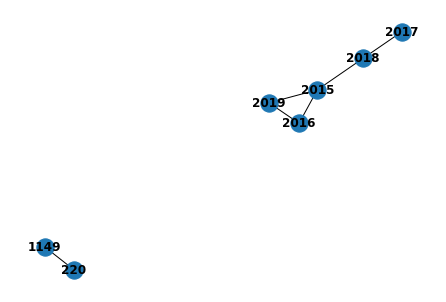

tensor([[2016, 2015, 2015, 2017, 2015, 1149],
        [2019, 2019, 2018, 2018, 2016,  220]])
f1_score, ged 0.8333333333333334 4.0
[0.17534226 0.18984991 0.4204604  0.01549125 0.4204604  0.34293252
 0.18984991 0.05009085 0.4264254 ]


<Figure size 432x288 with 0 Axes>

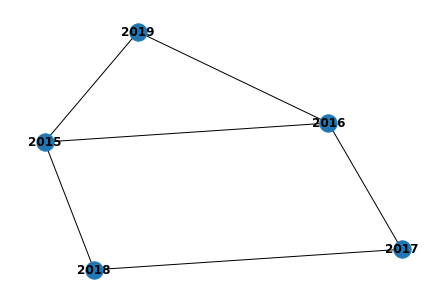

tensor([[2015, 2016, 2015, 2017, 2015, 2016],
        [2019, 2019, 2018, 2018, 2016, 2017]])
f1_score, ged 1.0 0.0
[1.22464895e-02 4.41122055e-03 7.96675682e-04 5.62334061e-03
 5.66244125e-05 3.92079353e-04 1.16348267e-03 7.37428665e-04
 3.09109688e-04 7.73830414e-02 8.67474079e-03 2.57881880e-02
 1.64734364e-01 5.59912920e-02 1.64734364e-01 8.67474079e-03
 2.57881880e-02 5.59912920e-02 5.47087193e-03 5.59912920e-02]


<Figure size 432x288 with 0 Axes>

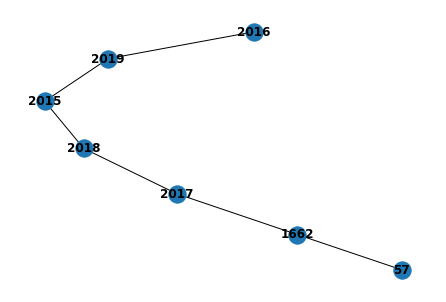

tensor([[2015, 2016, 1662, 2015, 2017,   57],
        [2019, 2019, 2017, 2018, 2018, 1662]])
f1_score, ged 0.6666666666666666 6.0
[0.02603137 0.23338819 0.46472955 0.00718439 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [33]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

for node_idx in list_node_idx:
    edge_mask = explain_occlusion(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [144]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.8166666666666668 3.55 0.8166666666666668 0.8166666666666668


In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Node_Explainer:
    def __init__(
            self,
            model,
            edge_index,
            X,
            num_layers,
            mode=0,
            print_result=1
    ):
        self.model = model
        self.model.eval()
        self.edge_index = edge_index
        self.X = X
        self.num_layers = num_layers
        self.mode = mode
        self.print_result = print_result

    def perturb_features_on_node(self, feature_matrix, node_idx, random=0, mode=0):
        # return a random perturbed feature matrix
        # random = 0 for nothing, 1 for random.
        # mode = 0 for random 0-1, 1 for scaling with original feature

        X_perturb = feature_matrix
        if mode == 0:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.random.randint(2, size=X_perturb[node_idx].shape[0])
            X_perturb[node_idx] = perturb_array
        elif mode == 1:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.multiply(X_perturb[node_idx],
                                            np.random.uniform(low=0.0, high=2.0, size=X_perturb[node_idx].shape[0]))
            X_perturb[node_idx] = perturb_array
        return X_perturb

    def explain(self, node_idx, target, num_samples=100, top_node=None, p_threshold=0.05, pred_threshold=0.1):
        neighbors, _, _, _ = k_hop_subgraph(node_idx, self.num_layers, self.edge_index)
        neighbors = neighbors.cpu().detach().numpy()

        if (node_idx not in neighbors):
            neighbors = np.append(neighbors, node_idx)

        pred_torch = self.model(self.X, self.edge_index).cpu()
        soft_pred = np.asarray([softmax(np.asarray(pred_torch[node_].data)) for node_ in range(self.X.shape[0])])

        pred_node = np.asarray(pred_torch[node_idx].data)
        label_node = np.argmax(pred_node)
        soft_pred_node = softmax(pred_node)

        Samples = []
        Pred_Samples = []

        for iteration in range(num_samples):

            X_perturb = self.X.cpu().detach().numpy()
            sample = []
            for node in neighbors:
                seed = np.random.randint(2)
                if seed == 1:
                    latent = 1
                    X_perturb = self.perturb_features_on_node(X_perturb, node, random=seed)
                else:
                    latent = 0
                sample.append(latent)

            X_perturb_torch = torch.tensor(X_perturb, dtype=torch.float).to(device)
            pred_perturb_torch = self.model(X_perturb_torch, self.edge_index).cpu()
            soft_pred_perturb = np.asarray(
                [softmax(np.asarray(pred_perturb_torch[node_].data)) for node_ in range(self.X.shape[0])])

            sample_bool = []
            for node in neighbors:
                if (soft_pred_perturb[node, target] + pred_threshold) < soft_pred[node, target]:
                    sample_bool.append(1)
                else:
                    sample_bool.append(0)

            Samples.append(sample)
            Pred_Samples.append(sample_bool)

        Samples = np.asarray(Samples)
        Pred_Samples = np.asarray(Pred_Samples)
        Combine_Samples = Samples - Samples
        for s in range(Samples.shape[0]):
            Combine_Samples[s] = np.asarray(
                [Samples[s, i] * 10 + Pred_Samples[s, i] + 1 for i in range(Samples.shape[1])])

        data_pgm = pd.DataFrame(Combine_Samples)
        data_pgm = data_pgm.rename(columns={0: 'A', 1: 'B'})  # Trick to use chi_square test on first two data columns
        ind_ori_to_sub = dict(zip(neighbors, list(data_pgm.columns)))

        p_values = []
        for node in neighbors:
            if node == node_idx:
                p = 0 # p<0.05 => we are confident that we can reject the null hypothesis (i.e. the prediction is the same after perturbing the neighbouring node 
                # => this neighbour has no influence on the prediction - should not be in the explanation)
            else:
                chi2, p,_ = chi_square(ind_ori_to_sub[node], ind_ori_to_sub[node_idx], [], data_pgm, boolean=False, significance_level=0.05)
            p_values.append(p)

        pgm_stats = dict(zip(neighbors, p_values))
        return pgm_stats

In [35]:
def explain_pgmexplainer(model, node_idx, x, edge_index, target, include_edges=None):
    explainer = Node_Explainer(model, edge_index, x, model.num_layers, print_result=0)
    explanation = explainer.explain(node_idx,target)
    node_attr = np.zeros(x.shape[0])
    for node, p_value in explanation.items():
        node_attr[node] = 1 - p_value
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

[0.51875682 0.51875682 0.51875682 0.51875682 0.51875682 0.51875682
 0.51875682 0.51875682 0.51875682 0.51875682 1.51875682 2.
 2.         1.99999999 2.         2.         1.99999999 2.
 2.         1.51875682 2.         2.         1.99999999 1.99999999]


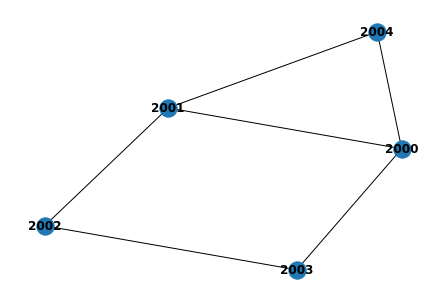

tensor([[2002, 2000, 2000, 2001, 2000, 2001],
        [2003, 2001, 2003, 2002, 2004, 2004]])
f1_score, ged 1.0 0.0
[0.49364384 1.0320932  0.52573704 0.55257066 1.0320932  1.52047746
 1.52047746 1.52047746 1.0141213  0.49364384 0.52573704 1.0141213
 0.55257066 1.52047746]


<Figure size 432x288 with 0 Axes>

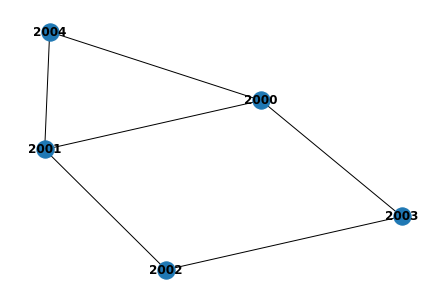

tensor([[2001, 2001, 2000, 2002, 2000, 2000],
        [2002, 2004, 2001, 2003, 2004, 2003]])
f1_score, ged 1.0 0.0
[0.045138   0.045138   0.045138   0.045138   0.045138   0.045138
 0.045138   0.045138   0.045138   0.045138   0.27226293 0.13793456
 0.22712493 0.35943989 0.13793456 1.13793456 0.49737445 1.13793456
 1.22712493 0.27226293 0.22712493 1.22712493 0.35943989 0.49737445]


<Figure size 432x288 with 0 Axes>

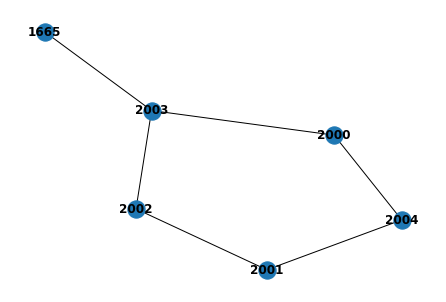

tensor([[2002, 2001, 2001, 2000, 1665, 2000],
        [2003, 2002, 2004, 2004, 2003, 2003]])
f1_score, ged 0.8333333333333334 3.0
[0.5786205  0.5786205  0.17502635 0.17502635 0.5786205  0.26998959
 0.28272525 0.5786205  0.28272525 0.90097158 0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.5786205  0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.5786205  0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.5786205  0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.84861009 0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.90097158 0.28272525 0.28272525
 0.5786205  0.17502635 0.5786205  0.5786205  0.17502635 0.5786205
 0.5786205  0.90097158 0.5786205  0.5786205  0.17502635 0.5786205
 0.5786205  0.28272525 0.28272525 0.28272525 0.28272525 0.28272525
 0.28272525 0.28272525 0.55271484 0.17502635 0.17502635 0.17502635
 0.17502635 0.17502635 0.17502635 0.44501594 0.90097158 0.5786205
 0.5786205  0.5786205  0.5786205  0.5786205  0.5786205  0.90097158
 0.9009

<Figure size 432x288 with 0 Axes>

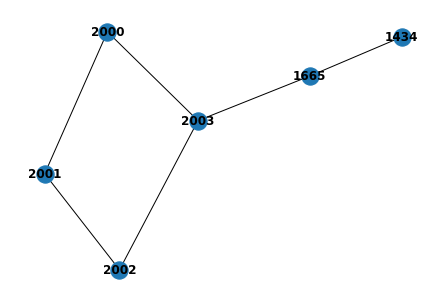

tensor([[2002, 2000, 1665, 1434, 2001, 2000],
        [2003, 2003, 2003, 1665, 2002, 2001]])
f1_score, ged 0.6666666666666666 3.0
[0.14941887 0.44898409 0.14941887 1.         0.44898409 0.88035944
 1.44898409 0.88035944 0.58079422 0.14941887 0.14941887 0.58079422
 1.         1.44898409]


<Figure size 432x288 with 0 Axes>

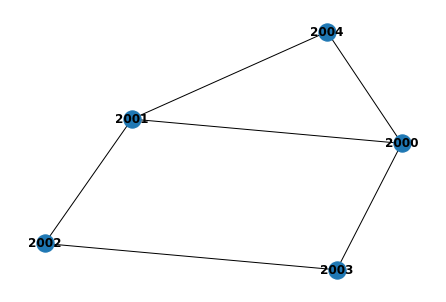

tensor([[2001, 2000, 2001, 2002, 2000, 2000],
        [2004, 2004, 2002, 2003, 2001, 2003]])
f1_score, ged 1.0 0.0
[0.59363772 0.59363772 0.59363772 0.59363772 0.59363772 0.59363772
 0.59363772 0.59363772 0.59363772 0.59363772 1.59363772 2.
 2.         1.99960565 2.         2.         1.99960565 2.
 2.         1.59363772 2.         2.         1.99960565 1.99960565]


<Figure size 432x288 with 0 Axes>

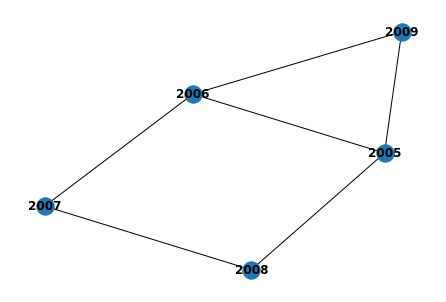

tensor([[2005, 2005, 2006, 2007, 2006, 2005],
        [2008, 2006, 2007, 2008, 2009, 2009]])
f1_score, ged 1.0 0.0


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [36]:
import time 


list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_pgmexplainer(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [ ]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision), np.mean(duration_samples))

In [42]:
import copy
import torch
import numpy as np
from scipy.special import comb
from itertools import combinations
import torch.nn.functional as F
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data, Batch, Dataset, DataLoader


def GnnNetsGC2valueFunc(gnnNets, target_class):
    def value_func(batch):
        with torch.no_grad():
            logits = gnnNets(data=batch)
            probs = F.softmax(logits, dim=-1)
            score = probs[:, target_class]
        return score
    return value_func


def GnnNetsNC2valueFunc(gnnNets_NC, node_idx, target_class):
    def value_func(data):
        with torch.no_grad():
            probs = gnnNets_NC(data.x, data.edge_index)
            # select the corresponding node prob through the node idx on all the sampling graphs
            batch_size = data.batch.max() + 1
            probs = probs.reshape(batch_size, -1, probs.shape[-1])
            score = probs[:, node_idx, target_class]
            return score
    return value_func


def get_graph_build_func(build_method):
    if build_method.lower() == 'zero_filling':
        return graph_build_zero_filling
    elif build_method.lower() == 'split':
        return graph_build_split
    else:
        raise NotImplementedError


class MarginalSubgraphDataset(Dataset):
    def __init__(self, data, exclude_mask, include_mask, subgraph_build_func):
        self.num_nodes = data.num_nodes
        self.X = data.x
        self.edge_index = data.edge_index
        self.device = self.X.device

        self.label = data.y
        self.exclude_mask = torch.tensor(exclude_mask).type(torch.float32).to(self.device)
        self.include_mask = torch.tensor(include_mask).type(torch.float32).to(self.device)
        self.subgraph_build_func = subgraph_build_func

    def __len__(self):
        return self.exclude_mask.shape[0]

    def __getitem__(self, idx):
        exclude_graph_X, exclude_graph_edge_index = self.subgraph_build_func(self.X, self.edge_index, self.exclude_mask[idx])
        include_graph_X, include_graph_edge_index = self.subgraph_build_func(self.X, self.edge_index, self.include_mask[idx])
        exclude_data = Data(x=exclude_graph_X, edge_index=exclude_graph_edge_index)
        include_data = Data(x=include_graph_X, edge_index=include_graph_edge_index)
        return exclude_data, include_data


def marginal_contribution(data: Data, exclude_mask: np.array, include_mask: np.array,
                          value_func, subgraph_build_func):
    """ Calculate the marginal value for each pair. Here exclude_mask and include_mask are node mask. """
    marginal_subgraph_dataset = MarginalSubgraphDataset(data, exclude_mask, include_mask, subgraph_build_func)
    dataloader = DataLoader(marginal_subgraph_dataset, batch_size=256, shuffle=False, num_workers=0)

    marginal_contribution_list = []

    for exclude_data, include_data in dataloader:
        exclude_values = value_func(exclude_data)
        include_values = value_func(include_data)
        margin_values = include_values - exclude_values
        marginal_contribution_list.append(margin_values)

    marginal_contributions = torch.cat(marginal_contribution_list, dim=0)
    return marginal_contributions


def graph_build_zero_filling(X, edge_index, node_mask: np.array):
    """ subgraph building through masking the unselected nodes with zero features """
    ret_X = X * node_mask.unsqueeze(1)
    return ret_X, edge_index


def graph_build_split(X, edge_index, node_mask: np.array):
    """ subgraph building through spliting the selected nodes from the original graph """
    ret_X = X
    row, col = edge_index
    edge_mask = (node_mask[row] == 1) & (node_mask[col] == 1)
    ret_edge_index = edge_index[:, edge_mask]
    return ret_X, ret_edge_index


def l_shapley(coalition: list, data: Data, local_radius: int,
              value_func: str, subgraph_building_method='zero_filling'):
    """ shapley value where players are local neighbor nodes """
    graph = to_networkx(data)
    num_nodes = graph.number_of_nodes()
    subgraph_build_func = get_graph_build_func(subgraph_building_method)

    local_region = copy.copy(coalition)
    for k in range(local_radius - 1):
        k_neiborhoood = []
        for node in local_region:
            k_neiborhoood += list(graph.neighbors(node))
        local_region += k_neiborhoood
        local_region = list(set(local_region))

    set_exclude_masks = []
    set_include_masks = []
    nodes_around = [node for node in local_region if node not in coalition]
    num_nodes_around = len(nodes_around)

    for subset_len in range(0, num_nodes_around + 1):
        node_exclude_subsets = combinations(nodes_around, subset_len)
        for node_exclude_subset in node_exclude_subsets:
            set_exclude_mask = np.ones(num_nodes)
            set_exclude_mask[local_region] = 0.0
            if node_exclude_subset:
                set_exclude_mask[list(node_exclude_subset)] = 1.0
            set_include_mask = set_exclude_mask.copy()
            set_include_mask[coalition] = 1.0

            set_exclude_masks.append(set_exclude_mask)
            set_include_masks.append(set_include_mask)

    exclude_mask = np.stack(set_exclude_masks, axis=0)
    include_mask = np.stack(set_include_masks, axis=0)
    num_players = len(nodes_around) + 1
    num_player_in_set = num_players - 1 + len(coalition) - (1 - exclude_mask).sum(axis=1)
    p = num_players
    S = num_player_in_set
    coeffs = torch.tensor(1.0 / comb(p, S) / (p - S + 1e-6))

    marginal_contributions = \
        marginal_contribution(data, exclude_mask, include_mask, value_func, subgraph_build_func)

    l_shapley_value = (marginal_contributions.squeeze().cpu() * coeffs).sum().item()
    return l_shapley_value


def mc_shapley(coalition: list, data: Data,
               value_func: str, subgraph_building_method='zero_filling',
               sample_num=1000) -> float:
    """ monte carlo sampling approximation of the shapley value """
    subset_build_func = get_graph_build_func(subgraph_building_method)

    num_nodes = data.num_nodes
    node_indices = np.arange(num_nodes)
    coalition_placeholder = num_nodes
    set_exclude_masks = []
    set_include_masks = []

    for example_idx in range(sample_num):
        subset_nodes_from = [node for node in node_indices if node not in coalition]
        random_nodes_permutation = np.array(subset_nodes_from + [coalition_placeholder])
        random_nodes_permutation = np.random.permutation(random_nodes_permutation)
        split_idx = np.where(random_nodes_permutation == coalition_placeholder)[0][0]
        selected_nodes = random_nodes_permutation[:split_idx]
        set_exclude_mask = np.zeros(num_nodes)
        set_exclude_mask[selected_nodes] = 1.0
        set_include_mask = set_exclude_mask.copy()
        set_include_mask[coalition] = 1.0

        set_exclude_masks.append(set_exclude_mask)
        set_include_masks.append(set_include_mask)

    exclude_mask = np.stack(set_exclude_masks, axis=0)
    include_mask = np.stack(set_include_masks, axis=0)
    marginal_contributions = marginal_contribution(data, exclude_mask, include_mask, value_func, subset_build_func)
    mc_shapley_value = marginal_contributions.mean().item()

    return mc_shapley_value


def mc_l_shapley(coalition: list, data: Data, local_radius: int,
                 value_func: str, subgraph_building_method='zero_filling',
                 sample_num=1000) -> float:
    """ monte carlo sampling approximation of the l_shapley value """
    graph = to_networkx(data)
    num_nodes = graph.number_of_nodes()
    subgraph_build_func = get_graph_build_func(subgraph_building_method)

    local_region = copy.copy(coalition)
    for k in range(local_radius - 1):
        k_neiborhoood = []
        for node in local_region:
            k_neiborhoood += list(graph.neighbors(node))
        local_region += k_neiborhoood
        local_region = list(set(local_region))

    coalition_placeholder = num_nodes
    set_exclude_masks = []
    set_include_masks = []
    for example_idx in range(sample_num):
        subset_nodes_from = [node for node in local_region if node not in coalition]
        random_nodes_permutation = np.array(subset_nodes_from + [coalition_placeholder])
        random_nodes_permutation = np.random.permutation(random_nodes_permutation)
        split_idx = np.where(random_nodes_permutation == coalition_placeholder)[0][0]
        selected_nodes = random_nodes_permutation[:split_idx]
        set_exclude_mask = np.ones(num_nodes)
        set_exclude_mask[local_region] = 0.0
        set_exclude_mask[selected_nodes] = 1.0
        set_include_mask = set_exclude_mask.copy()
        set_include_mask[coalition] = 1.0

        set_exclude_masks.append(set_exclude_mask)
        set_include_masks.append(set_include_mask)

    exclude_mask = np.stack(set_exclude_masks, axis=0)
    include_mask = np.stack(set_include_masks, axis=0)
    marginal_contributions = \
        marginal_contribution(data, exclude_mask, include_mask, value_func, subgraph_build_func)

    mc_l_shapley_value = (marginal_contributions).mean().item()
    return mc_l_shapley_value


def gnn_score(coalition: list, data: Data, value_func: str,
              subgraph_building_method='zero_filling') -> torch.Tensor:
    """ the value of subgraph with selected nodes """
    num_nodes = data.num_nodes
    subgraph_build_func = get_graph_build_func(subgraph_building_method)
    mask = torch.zeros(num_nodes).type(torch.float32).to(data.x.device)
    mask[coalition] = 1.0
    ret_x, ret_edge_index = subgraph_build_func(data.x, data.edge_index, mask)
    mask_data = Data(x=ret_x, edge_index=ret_edge_index)
    mask_data = Batch.from_data_list([mask_data])
    score = value_func(mask_data)
    # get the score of predicted class for graph or specific node idx
    return score.item()


def NC_mc_l_shapley(coalition: list, data: Data, local_radius: int,
                    value_func: str, node_idx: int = -1,
                    subgraph_building_method='zero_filling', sample_num=1000) -> float:
    """ monte carlo approximation of l_shapley where the target node is kept in both subgraph """
    graph = to_networkx(data)
    num_nodes = graph.number_of_nodes()
    subgraph_build_func = get_graph_build_func(subgraph_building_method)

    local_region = copy.copy(coalition)
    for k in range(local_radius - 1):
        k_neiborhoood = []
        for node in local_region:
            k_neiborhoood += list(graph.neighbors(node))
        local_region += k_neiborhoood
        local_region = list(set(local_region))

    coalition_placeholder = num_nodes
    set_exclude_masks = []
    set_include_masks = []
    for example_idx in range(sample_num):
        subset_nodes_from = [node for node in local_region if node not in coalition]
        random_nodes_permutation = np.array(subset_nodes_from + [coalition_placeholder])
        random_nodes_permutation = np.random.permutation(random_nodes_permutation)
        split_idx = np.where(random_nodes_permutation == coalition_placeholder)[0][0]
        selected_nodes = random_nodes_permutation[:split_idx]
        set_exclude_mask = np.ones(num_nodes)
        set_exclude_mask[local_region] = 0.0
        set_exclude_mask[selected_nodes] = 1.0
        if node_idx != -1:
            set_exclude_mask[node_idx] = 1.0
        set_include_mask = set_exclude_mask.copy()
        set_include_mask[coalition] = 1.0  # include the node_idx

        set_exclude_masks.append(set_exclude_mask)
        set_include_masks.append(set_include_mask)

    exclude_mask = np.stack(set_exclude_masks, axis=0)
    include_mask = np.stack(set_include_masks, axis=0)
    marginal_contributions = \
        marginal_contribution(data, exclude_mask, include_mask, value_func, subgraph_build_func)

    mc_l_shapley_value = (marginal_contributions).mean().item()
    return mc_l_shapley_value


def sparsity(coalition: list, data: Data, subgraph_building_method='zero_filling'):
    if subgraph_building_method == 'zero_filling':
        return 1.0 - len(coalition) / data.num_nodes

    elif subgraph_building_method == 'split':
        row, col = data.edge_index
        node_mask = torch.zeros(data.x.shape[0])
        node_mask[coalition] = 1.0
        edge_mask = (node_mask[row] == 1) & (node_mask[col] == 1)
        return 1.0 - edge_mask.sum() / edge_mask.shape[0]

In [61]:
import os
import math
import copy
import torch
import numpy as np
import networkx as nx
from torch import Tensor
from textwrap import wrap
from functools import partial
from collections import Counter
from typing import List, Tuple, Dict
from torch_geometric.data import Batch, Data
from torch_geometric.utils import to_networkx
from typing import Callable, Union, Optional
import matplotlib.pyplot as plt
from torch_geometric.utils.num_nodes import maybe_num_nodes
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils import remove_self_loops


def find_closest_node_result(results, max_nodes):
    """ return the highest reward tree_node with its subgraph is smaller than max_nodes """
    results = sorted(results, key=lambda x: len(x.coalition))
    
    result_node = results[0]
    for result_idx in range(len(results)):
        x = results[result_idx]
        if len(x.coalition) <= max_nodes and x.P > result_node.P:
            result_node = x
    return result_node


def reward_func(reward_method, value_func, node_idx=None,
                local_radius=4, sample_num=100,
                subgraph_building_method='zero_filling'):
    if reward_method.lower() == 'gnn_score':
        return partial(gnn_score,
                       value_func=value_func,
                       subgraph_building_method=subgraph_building_method)

    elif reward_method.lower() == 'mc_shapley':
        return partial(mc_shapley,
                       value_func=value_func,
                       subgraph_building_method=subgraph_building_method,
                       sample_num=sample_num)

    elif reward_method.lower() == 'l_shapley':
        return partial(l_shapley,
                       local_radius=local_radius,
                       value_func=value_func,
                       subgraph_building_method=subgraph_building_method)

    elif reward_method.lower() == 'mc_l_shapley':
        return partial(mc_l_shapley,
                       local_radius=local_radius,
                       value_func=value_func,
                       subgraph_building_method=subgraph_building_method,
                       sample_num=sample_num)

    elif reward_method.lower() == 'nc_mc_l_shapley':
        assert node_idx is not None, " Wrong node idx input "
        return partial(NC_mc_l_shapley,
                       node_idx=node_idx,
                       local_radius=local_radius,
                       value_func=value_func,
                       subgraph_building_method=subgraph_building_method,
                       sample_num=sample_num)

    else:
        raise NotImplementedError


def k_hop_subgraph_with_default_whole_graph(
        edge_index, node_idx=None, num_hops=3, relabel_nodes=False,
        num_nodes=None, flow='source_to_target'):
    r"""Computes the :math:`k`-hop subgraph of :obj:`edge_index` around node
    :attr:`node_idx`.
    It returns (1) the nodes involved in the subgraph, (2) the filtered
    :obj:`edge_index` connectivity, (3) the mapping from node indices in
    :obj:`node_idx` to their new location, and (4) the edge mask indicating
    which edges were preserved.
    Args:
        node_idx (int, list, tuple or :obj:`torch.Tensor`): The central
            node(s).
        num_hops: (int): The number of hops :math:`k`.
        edge_index (LongTensor): The edge indices.
        relabel_nodes (bool, optional): If set to :obj:`True`, the resulting
            :obj:`edge_index` will be relabeled to hold consecutive indices
            starting from zero. (default: :obj:`False`)
        num_nodes (int, optional): The number of nodes, *i.e.*
            :obj:`max_val + 1` of :attr:`edge_index`. (default: :obj:`None`)
        flow (string, optional): The flow direction of :math:`k`-hop
            aggregation (:obj:`"source_to_target"` or
            :obj:`"target_to_source"`). (default: :obj:`"source_to_target"`)
    :rtype: (:class:`LongTensor`, :class:`LongTensor`, :class:`LongTensor`,
             :class:`BoolTensor`)
    """

    num_nodes = maybe_num_nodes(edge_index, num_nodes)

    assert flow in ['source_to_target', 'target_to_source']
    if flow == 'target_to_source':
        row, col = edge_index
    else:
        col, row = edge_index  # edge_index 0 to 1, col: source, row: target

    node_mask = row.new_empty(num_nodes, dtype=torch.bool)
    edge_mask = row.new_empty(row.size(0), dtype=torch.bool)

    inv = None

    if node_idx is None:
        subsets = torch.tensor([0])
        cur_subsets = subsets
        while 1:
            node_mask.fill_(False)
            node_mask[subsets] = True
            torch.index_select(node_mask, 0, row, out=edge_mask)
            subsets = torch.cat([subsets, col[edge_mask]]).unique()
            if not cur_subsets.equal(subsets):
                cur_subsets = subsets
            else:
                subset = subsets
                break
    else:
        if isinstance(node_idx, (int, list, tuple)):
            node_idx = torch.tensor([node_idx], device=row.device, dtype=torch.int64).flatten()
        elif isinstance(node_idx, torch.Tensor) and len(node_idx.shape) == 0:
            node_idx = torch.tensor([node_idx])
        else:
            node_idx = node_idx.to(row.device)

        subsets = [node_idx]
        for _ in range(num_hops):
            node_mask.fill_(False)
            node_mask[subsets[-1]] = True
            torch.index_select(node_mask, 0, row, out=edge_mask)
            subsets.append(col[edge_mask])
        subset, inv = torch.cat(subsets).unique(return_inverse=True)
        inv = inv[:node_idx.numel()]

    node_mask.fill_(False)
    node_mask[subset] = True
    edge_mask = node_mask[row] & node_mask[col]

    edge_index = edge_index[:, edge_mask]

    if relabel_nodes:
        node_idx = row.new_full((num_nodes,), -1)
        node_idx[subset] = torch.arange(subset.size(0), device=row.device)
        edge_index = node_idx[edge_index]

    return subset, edge_index, inv, edge_mask  # subset: key new node idx; value original node idx


def compute_scores(score_func, children):
    results = []
    for child in children:
        if child.P == 0:
            score = score_func(child.coalition, child.data)
        else:
            score = child.P
        results.append(score)
    return results


class PlotUtils(object):
    def __init__(self, dataset_name, is_show=True):
        self.dataset_name = dataset_name
        self.is_show = is_show

    def plot(self, graph, nodelist, figname, title_sentence=None, **kwargs):
        """ plot function for different dataset """
        if self.dataset_name.lower() in ['ba_2motifs', 'ba_lrp']:
            self.plot_ba2motifs(graph, nodelist, title_sentence=title_sentence, figname=figname)
        elif self.dataset_name.lower() in ['mutag'] + list(MoleculeNet.names.keys()):
            x = kwargs.get('x')
            self.plot_molecule(graph, nodelist, x, title_sentence=title_sentence, figname=figname)
        elif self.dataset_name.lower() in ['ba_shapes', 'ba_community', 'tree_grid', 'tree_cycle']:
            y = kwargs.get('y')
            node_idx = kwargs.get('node_idx')
            self.plot_bashapes(graph, nodelist, y, node_idx, title_sentence=title_sentence, figname=figname)
        elif self.dataset_name.lower() in ['graph_sst2', 'graph_sst5', 'twitter']:
            words = kwargs.get('words')
            self.plot_sentence(graph, nodelist, words=words, title_sentence=title_sentence, figname=figname)
        else:
            raise NotImplementedError

    def plot_subgraph(self,
                      graph,
                      nodelist,
                      colors: Union[None, str, List[str]] = '#FFA500',
                      labels=None,
                      edge_color='gray',
                      edgelist=None,
                      subgraph_edge_color='black',
                      title_sentence=None,
                      figname=None):

        if edgelist is None:
            edgelist = [(n_frm, n_to) for (n_frm, n_to) in graph.edges()
                        if n_frm in nodelist and n_to in nodelist]
        pos = nx.kamada_kawai_layout(graph)
        pos_nodelist = {k: v for k, v in pos.items() if k in nodelist}

        nx.draw_networkx_nodes(graph, pos,
                               nodelist=list(graph.nodes()),
                               node_color=colors,
                               node_size=300)

        nx.draw_networkx_edges(graph, pos, width=3, edge_color=edge_color, arrows=False)

        nx.draw_networkx_edges(graph, pos=pos_nodelist,
                               edgelist=edgelist, width=6,
                               edge_color=subgraph_edge_color,
                               arrows=False)

        if labels is not None:
            nx.draw_networkx_labels(graph, pos, labels)

        plt.axis('off')
        if figname is not None:
            plt.savefig(figname)
        if title_sentence is not None:
            plt.title('\n'.join(wrap(title_sentence, width=60)))
        if self.is_show:
            plt.show()
        if figname is not None:
            plt.close()

    def plot_subgraph_with_nodes(self,
                                 graph,
                                 nodelist,
                                 node_idx,
                                 colors='#FFA500',
                                 labels=None,
                                 edge_color='gray',
                                 edgelist=None,
                                 subgraph_edge_color='black',
                                 title_sentence=None,
                                 figname=None):
        node_idx = int(node_idx)
        if edgelist is None:
            edgelist = [(n_frm, n_to) for (n_frm, n_to) in graph.edges()
                        if n_frm in nodelist and n_to in nodelist]

        pos = nx.kamada_kawai_layout(graph)  # calculate according to graph.nodes()
        pos_nodelist = {k: v for k, v in pos.items() if k in nodelist}

        nx.draw_networkx_nodes(graph, pos,
                               nodelist=list(graph.nodes()),
                               node_color=colors,
                               node_size=300)
        if isinstance(colors, list):
            list_indices = int(np.where(np.array(graph.nodes()) == node_idx)[0])
            node_idx_color = colors[list_indices]
        else:
            node_idx_color = colors

        nx.draw_networkx_nodes(graph, pos=pos,
                               nodelist=[node_idx],
                               node_color=node_idx_color,
                               node_size=600)

        nx.draw_networkx_edges(graph, pos, width=3, edge_color=edge_color, arrows=False)

        nx.draw_networkx_edges(graph, pos=pos_nodelist,
                               edgelist=edgelist, width=3,
                               edge_color=subgraph_edge_color,
                               arrows=False)

        if labels is not None:
            nx.draw_networkx_labels(graph, pos, labels)

        plt.axis('off')
        if title_sentence is not None:
            plt.title('\n'.join(wrap(title_sentence, width=60)))

        if figname is not None:
            plt.savefig(figname)
        if self.is_show:
            plt.show()
        if figname is not None:
            plt.close()

    def plot_sentence(self, graph, nodelist, words, edgelist=None, title_sentence=None, figname=None):
        pos = nx.kamada_kawai_layout(graph)
        words_dict = {i: words[i] for i in graph.nodes}
        if nodelist is not None:
            pos_coalition = {k: v for k, v in pos.items() if k in nodelist}
            nx.draw_networkx_nodes(graph, pos_coalition,
                                   nodelist=nodelist,
                                   node_color='yellow',
                                   node_shape='o',
                                   node_size=500)
            if edgelist is None:
                edgelist = [(n_frm, n_to) for (n_frm, n_to) in graph.edges()
                            if n_frm in nodelist and n_to in nodelist]
                nx.draw_networkx_edges(graph, pos=pos_coalition, edgelist=edgelist, width=5, edge_color='yellow')

        nx.draw_networkx_nodes(graph, pos, nodelist=list(graph.nodes()), node_size=300)

        nx.draw_networkx_edges(graph, pos, width=2, edge_color='grey')
        nx.draw_networkx_labels(graph, pos, words_dict)

        plt.axis('off')
        plt.title('\n'.join(wrap(' '.join(words), width=50)))
        if title_sentence is not None:
            string = '\n'.join(wrap(' '.join(words), width=50))
            string += '\n'.join(wrap(title_sentence, width=60))
            plt.title(string)
        if figname is not None:
            plt.savefig(figname)
        if self.is_show:
            plt.show()
        if figname is not None:
            plt.close()

    def plot_bashapes(self,
                      graph,
                      nodelist,
                      y,
                      node_idx,
                      edgelist=None,
                      title_sentence=None,
                      figname=None):
        node_idxs = {k: int(v) for k, v in enumerate(y.reshape(-1).tolist())}
        node_color = ['#FFA500', '#4970C6', '#FE0000', 'green']
        colors = [node_color[v % len(node_color)] for k, v in node_idxs.items()]
        self.plot_subgraph_with_nodes(graph,
                                      nodelist,
                                      node_idx,
                                      colors,
                                      edgelist=edgelist,
                                      title_sentence=title_sentence,
                                      figname=figname,
                                      subgraph_edge_color='black')


class MCTSNode(object):
    def __init__(self, coalition: list = None, data: Data = None, ori_graph: nx.Graph = None,
                 c_puct: float = 10.0, W: float = 0, N: int = 0, P: float = 0,
                 load_dict: Optional[Dict] = None, device='cpu'):
        self.data = data
        self.coalition = coalition
        self.ori_graph = ori_graph
        self.device = device
        self.c_puct = c_puct
        self.children = []
        self.W = W  # sum of node value
        self.N = N  # times of arrival
        self.P = P  # property score (reward)
        if load_dict is not None:
            self.load_info(load_dict)

    def Q(self):
        return self.W / self.N if self.N > 0 else 0

    def U(self, n):
        return self.c_puct * self.P * math.sqrt(n) / (1 + self.N)

    @property
    def info(self):
        info_dict = {
            'data': self.data.to('cpu'),
            'coalition': self.coalition,
            'ori_graph': self.ori_graph,
            'W': self.W,
            'N': self.N,
            'P': self.P
        }
        return info_dict

    def load_info(self, info_dict):
        self.W = info_dict['W']
        self.N = info_dict['N']
        self.P = info_dict['P']
        self.coalition = info_dict['coalition']
        self.ori_graph = info_dict['ori_graph']
        self.data = info_dict['data'].to(self.device)
        self.children = []
        return self


class MCTS(object):
    r"""
    Monte Carlo Tree Search Method.
    
    Args:
        X (:obj:`torch.Tensor`): Input node features
        edge_index (:obj:`torch.Tensor`): The edge indices.
        num_hops (:obj:`int`): The number of hops :math:`k`.
        n_rollout (:obj:`int`): The number of sequence to build the monte carlo tree.
        min_atoms (:obj:`int`): The number of atoms for the subgraph in the monte carlo tree leaf node.
        c_puct (:obj:`float`): The hyper-parameter to encourage exploration while searching.
        expand_atoms (:obj:`int`): The number of children to expand.
        high2low (:obj:`bool`): Whether to expand children tree node from high degree nodes to low degree nodes.
        node_idx (:obj:`int`): The target node index to extract the neighborhood.
        score_func (:obj:`Callable`): The reward function for tree node, such as mc_shapely and mc_l_shapely.
    """
    def __init__(self, X: torch.Tensor, edge_index: torch.Tensor, num_hops: int,
                 n_rollout: int = 10, min_atoms: int = 3, c_puct: float = 10.0,
                 expand_atoms: int = 14, high2low: bool = False,
                 node_idx: int = None, score_func: Callable = None, device='cpu'):

        self.X = X
        self.edge_index = edge_index
        self.device = device
        self.num_hops = num_hops
        self.data = Data(x=self.X, edge_index=self.edge_index)
        graph_data = Data(x=self.X, edge_index=remove_self_loops(self.edge_index)[0])
        self.graph = to_networkx(graph_data, to_undirected=True)
        self.data = Batch.from_data_list([self.data])
        self.num_nodes = self.graph.number_of_nodes()
        self.score_func = score_func
        self.n_rollout = n_rollout
        self.min_atoms = min_atoms
        self.c_puct = c_puct
        self.expand_atoms = expand_atoms
        self.high2low = high2low
        self.new_node_idx = None

        # extract the sub-graph and change the node indices.
        if node_idx is not None:
            self.ori_node_idx = node_idx
            self.ori_graph = copy.copy(self.graph)
            x, edge_index, subset, edge_mask, kwargs = \
                self.__subgraph__(node_idx, self.X, self.edge_index, self.num_hops)
            self.ori_data = copy.copy(self.data)
            self.data = Batch.from_data_list([Data(x=x, edge_index=edge_index)])
            self.graph = self.ori_graph.subgraph(subset.tolist())
            mapping = {int(v): k for k, v in enumerate(subset)}
            self.mapping_inv = {int(k): int(v) for k, v in enumerate(subset)}
            self.graph = nx.relabel_nodes(self.graph, mapping)
            self.new_node_idx = torch.where(subset == self.ori_node_idx)[0].item()
            self.num_nodes = self.graph.number_of_nodes()
        
            self.subset = subset

        self.root_coalition = sorted([node for node in range(self.num_nodes)])
        self.MCTSNodeClass = partial(MCTSNode, data=self.data, ori_graph=self.graph,
                                     c_puct=self.c_puct, device=self.device)
        self.root = self.MCTSNodeClass(self.root_coalition)
        self.state_map = {str(self.root.coalition): self.root}

    def set_score_func(self, score_func):
        self.score_func = score_func

    @staticmethod
    def __subgraph__(node_idx, x, edge_index, num_hops, **kwargs):
        num_nodes, num_edges = x.size(0), edge_index.size(1)
        subset, edge_index, _, edge_mask = k_hop_subgraph(node_idx, num_hops, edge_index, relabel_nodes=True,
                   num_nodes=num_nodes, flow='source_to_target')
        #subset, edge_index, _, edge_mask = k_hop_subgraph_with_default_whole_graph(
            #edge_index, node_idx, num_hops, relabel_nodes=True, num_nodes=num_nodes)

        x = x[subset]
        for key, item in kwargs.items():
            if torch.is_tensor(item) and item.size(0) == num_nodes:
                item = item[subset]
            elif torch.is_tensor(item) and item.size(0) == num_edges:
                item = item[edge_mask]
            kwargs[key] = item

        return x, edge_index, subset, edge_mask, kwargs

    def mcts_rollout(self, tree_node):
        cur_graph_coalition = tree_node.coalition
        if len(cur_graph_coalition) <= self.min_atoms:
            return tree_node.P

        # Expand if this node has never been visited
        if len(tree_node.children) == 0:
            node_degree_list = list(self.graph.subgraph(cur_graph_coalition).degree)
            node_degree_list = sorted(node_degree_list, key=lambda x: x[1], reverse=self.high2low)
            all_nodes = [x[0] for x in node_degree_list]
            
            if self.new_node_idx:
                expand_nodes = [node for node in all_nodes if node != self.new_node_idx]
            else:
                expand_nodes = all_nodes

            if len(all_nodes) > self.expand_atoms:
                expand_nodes = expand_nodes[:self.expand_atoms]
                
            for each_node in expand_nodes:
                # for each node, pruning it and get the remaining sub-graph
                # here we check the resulting sub-graphs and only keep the largest one
                subgraph_coalition = [node for node in all_nodes if node != each_node]
                
                subgraphs = [self.graph.subgraph(c)
                             for c in nx.connected_components(self.graph.subgraph(subgraph_coalition))]

                if self.new_node_idx:
                    for sub in subgraphs:
                        if self.new_node_idx in list(sub.nodes()):
                            main_sub = sub
                else:
                    main_sub = subgraphs[0]
                    for sub in subgraphs:
                        if sub.number_of_nodes() > main_sub.number_of_nodes():
                            main_sub = sub

                new_graph_coalition = sorted(list(main_sub.nodes()))

                # check the state map and merge the same sub-graph
                find_same = False
                for old_graph_node in self.state_map.values():
                    if Counter(old_graph_node.coalition) == Counter(new_graph_coalition):
                        new_node = old_graph_node
                        find_same = True

                if not find_same:
                    new_node = self.MCTSNodeClass(new_graph_coalition)
                    self.state_map[str(new_graph_coalition)] = new_node

                find_same_child = False
                for cur_child in tree_node.children:
                    if Counter(cur_child.coalition) == Counter(new_graph_coalition):
                        find_same_child = True

                if not find_same_child:
                    tree_node.children.append(new_node)
            scores = compute_scores(self.score_func, tree_node.children)
            for child, score in zip(tree_node.children, scores):
                child.P = score

        sum_count = sum([c.N for c in tree_node.children])
        selected_node = max(tree_node.children, key=lambda x: x.Q() + x.U(sum_count))
        v = self.mcts_rollout(selected_node)
        selected_node.W += v
        selected_node.N += 1
        return v

    def mcts(self, verbose=True):
        if verbose:
            print(f"The nodes in graph is {self.graph.number_of_nodes()}")
        for rollout_idx in range(self.n_rollout):
            self.mcts_rollout(self.root)
            if verbose:
                print(f"At the {rollout_idx} rollout, {len(self.state_map)} states that have been explored.")

        explanations = [node for _, node in self.state_map.items()]
        explanations = sorted(explanations, key=lambda x: x.P, reverse=True)
        return explanations


class SubgraphX(object):
    r"""
    The implementation of paper
    `On Explainability of Graph Neural Networks via Subgraph Explorations <https://arxiv.org/abs/2102.05152>`_.
    
    Args:
        model (:obj:`torch.nn.Module`): The target model prepared to explain
        num_classes(:obj:`int`): Number of classes for the datasets
        num_hops(:obj:`int`, :obj:`None`): The number of hops to extract neighborhood of target node
          (default: :obj:`None`)
        explain_graph(:obj:`bool`): Whether to explain graph classification model (default: :obj:`True`)
        rollout(:obj:`int`): Number of iteration to get the prediction
        min_atoms(:obj:`int`): Number of atoms of the leaf node in search tree
        c_puct(:obj:`float`): The hyperparameter which encourages the exploration
        expand_atoms(:obj:`int`): The number of atoms to expand
          when extend the child nodes in the search tree
        high2low(:obj:`bool`): Whether to expand children nodes from high degree to low degree when
          extend the child nodes in the search tree (default: :obj:`False`)
        local_radius(:obj:`int`): Number of local radius to calculate :obj:`l_shapley`, :obj:`mc_l_shapley`
        sample_num(:obj:`int`): Sampling time of monte carlo sampling approximation for
          :obj:`mc_shapley`, :obj:`mc_l_shapley` (default: :obj:`mc_l_shapley`)
        reward_method(:obj:`str`): The command string to select the
        subgraph_building_method(:obj:`str`): The command string for different subgraph building method,
          such as :obj:`zero_filling`, :obj:`split` (default: :obj:`zero_filling`)
        save_dir(:obj:`str`, :obj:`None`): Root directory to save the explanation results (default: :obj:`None`)
        filename(:obj:`str`): The filename of results
        vis(:obj:`bool`): Whether to show the visualization (default: :obj:`True`)
    Example:
        >>> # For graph classification task
        >>> subgraphx = SubgraphX(model=model, num_classes=2)
        >>> _, explanation_results, related_preds = subgraphx(x, edge_index)
    """
    def __init__(self, model, num_classes: int, device, num_hops: Optional[int] = None, verbose: bool = False,
                 explain_graph: bool = True, rollout: int = 20, min_atoms: int = 5, c_puct: float = 10.0,
                 expand_atoms=14, high2low=False, local_radius=4, sample_num=100, reward_method='mc_l_shapley',
                 subgraph_building_method='zero_filling', save_dir: Optional[str] = None,
                 filename: str = 'example', vis: bool = True):

        self.model = model
        self.model.eval()
        self.device = device
        self.model.to(self.device)
        self.num_classes = num_classes
        self.num_hops = self.update_num_hops(num_hops)
        self.explain_graph = explain_graph
        self.verbose = verbose

        # mcts hyper-parameters
        self.rollout = rollout
        self.min_atoms = min_atoms
        self.c_puct = c_puct
        self.expand_atoms = expand_atoms
        self.high2low = high2low

        # reward function hyper-parameters
        self.local_radius = local_radius
        self.sample_num = sample_num
        self.reward_method = reward_method
        self.subgraph_building_method = subgraph_building_method

        # saving and visualization
        self.vis = vis
        self.save_dir = save_dir
        self.filename = filename
        self.save = True if self.save_dir is not None else False

    def update_num_hops(self, num_hops):
        if num_hops is not None:
            return num_hops

        k = 0
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                k += 1
        return k

    def get_reward_func(self, value_func, node_idx=None):
        if self.explain_graph:
            node_idx = None
        else:
            assert node_idx is not None
        return reward_func(reward_method=self.reward_method,
                           value_func=value_func,
                           node_idx=node_idx,
                           local_radius=self.local_radius,
                           sample_num=self.sample_num,
                           subgraph_building_method=self.subgraph_building_method)

    def get_mcts_class(self, x, edge_index, node_idx: int = None, score_func: Callable = None):
        if self.explain_graph:
            node_idx = None
        else:
            assert node_idx is not None
        return MCTS(x, edge_index,
                    node_idx=node_idx,
                    device=self.device,
                    score_func=score_func,
                    num_hops=self.num_hops,
                    n_rollout=self.rollout,
                    min_atoms=self.min_atoms,
                    c_puct=self.c_puct,
                    expand_atoms=self.expand_atoms,
                    high2low=self.high2low)

    def visualization(self, results: list,
                      max_nodes: int, plot_utils: PlotUtils, words: Optional[list] = None,
                      y: Optional[Tensor] = None, title_sentence: Optional[str] = None,
                      vis_name: Optional[str] = None):
        if self.save:
            if vis_name is None:
                vis_name = f"{self.filename}.png"
        else:
            vis_name = None
        tree_node_x = find_closest_node_result(results, max_nodes=max_nodes)
        if self.explain_graph:
            if words is not None:
                plot_utils.plot(tree_node_x.ori_graph,
                                tree_node_x.coalition,
                                words=words,
                                title_sentence=title_sentence,
                                figname=vis_name)
            else:
                plot_utils.plot(tree_node_x.ori_graph,
                                tree_node_x.coalition,
                                x=tree_node_x.data.x,
                                title_sentence=title_sentence,
                                figname=vis_name)
        else:
            subset = self.mcts_state_map.subset
            subgraph_y = y[subset].to('cpu')
            subgraph_y = torch.tensor([subgraph_y[node].item()
                                       for node in tree_node_x.ori_graph.nodes()])
            plot_utils.plot(tree_node_x.ori_graph,
                            tree_node_x.coalition,
                            node_idx=self.mcts_state_map.new_node_idx,
                            title_sentence=title_sentence,
                            y=subgraph_y,
                            figname=vis_name)

    def read_from_MCTSInfo_list(self, MCTSInfo_list):
        if isinstance(MCTSInfo_list[0], dict):
            ret_list = [MCTSNode(device=self.device).load_info(node_info) for node_info in MCTSInfo_list]
        elif isinstance(MCTSInfo_list[0][0], dict):
            ret_list = []
            for single_label_MCTSInfo_list in MCTSInfo_list:
                single_label_ret_list = [MCTSNode(device=self.device).load_info(node_info) for node_info in single_label_MCTSInfo_list]
                ret_list.append(single_label_ret_list)
        return ret_list

    def write_from_MCTSNode_list(self, MCTSNode_list):
        if isinstance(MCTSNode_list[0], MCTSNode):
            ret_list = [node.info for node in MCTSNode_list]
        elif isinstance(MCTSNode_list[0][0], MCTSNode):
            ret_list = []
            for single_label_MCTSNode_list in MCTSNode_list:
                single_label_ret_list = [node.info for node in single_label_MCTSNode_list]
                ret_list.append(single_label_ret_list)
        return ret_list

    def explain(self, x: Tensor, edge_index: Tensor, label: int,
                max_nodes: int = 6,
                node_idx: Optional[int] = None,
                saved_MCTSInfo_list: Optional[List[List]] = None):
        probs = self.model(x, edge_index)#.squeeze().softmax(dim=-1)
        if self.explain_graph:
            if saved_MCTSInfo_list:
                results = self.read_from_MCTSInfo_list(saved_MCTSInfo_list)

            if not saved_MCTSInfo_list:
                value_func = GnnNetsGC2valueFunc(self.model, target_class=label)
                payoff_func = self.get_reward_func(value_func)
                self.mcts_state_map = self.get_mcts_class(x, edge_index, score_func=payoff_func)
                results = self.mcts_state_map.mcts(verbose=self.verbose)

            # l sharply score
            value_func = GnnNetsGC2valueFunc(self.model, target_class=label)
            tree_node_x = find_closest_node_result(results, max_nodes=max_nodes)

        else:
            if saved_MCTSInfo_list:
                results = self.read_from_MCTSInfo_list(saved_MCTSInfo_list)

            self.mcts_state_map = self.get_mcts_class(x, edge_index, node_idx=node_idx)
            self.new_node_idx = self.mcts_state_map.new_node_idx
            # mcts will extract the subgraph and relabel the nodes
            value_func = GnnNetsNC2valueFunc(self.model,
                                             node_idx=self.mcts_state_map.new_node_idx,
                                             target_class=label)
            if not saved_MCTSInfo_list:
                payoff_func = self.get_reward_func(value_func,
                                                   node_idx=self.mcts_state_map.new_node_idx)
                self.mcts_state_map.set_score_func(payoff_func)
                results = self.mcts_state_map.mcts(verbose=self.verbose)
            
            self.mapping_inv = self.mcts_state_map.mapping_inv
            self.ori_data = self.mcts_state_map.ori_data
            tree_node_x = find_closest_node_result(results, max_nodes=max_nodes)
        print("tree_node_x coalition", tree_node_x.coalition)
        # keep the important structure
        masked_node_list = [node for node in range(tree_node_x.data.x.shape[0])
                            if node in tree_node_x.coalition]

        edges = tree_node_x.data.edge_index
        edge_mask = np.ones(edges.shape[1])
        for node in masked_node_list:
            for j in range(edges.shape[1]):
                if (edges[0][j]!= node) | (edges[1][j]!= node):
                    edge_mask[j] = 0
                    
        # remove the important structure, for node_classification,
        # remain the node_idx when remove the important structure
        maskout_node_list = [node for node in range(tree_node_x.data.x.shape[0])
                             if node not in tree_node_x.coalition]
        if not self.explain_graph:
            maskout_node_list += [self.new_node_idx]
            
            
        num_nodes = tree_node_x.data.num_nodes
        subgraph_build_func = get_graph_build_func(self.subgraph_building_method)
        mask = torch.zeros(num_nodes).type(torch.float32).to(tree_node_x.data.x.device)
        mask[masked_node_list] = 1.0
        print("tree_node_x.data.edge_index", tree_node_x.data.edge_index)
        ret_x, ret_edge_index = subgraph_build_func(tree_node_x.data.x, tree_node_x.data.edge_index, mask)
        print("ret_edge_index", ret_edge_index)
        mask_data = Data(x=ret_x, edge_index=ret_edge_index)
        mask_data = Batch.from_data_list([mask_data])
        #plt.figure()
        print("mask_node_list", masked_node_list)
        nx.draw(to_networkx(mask_data))

        masked_score = gnn_score(masked_node_list,
                                 tree_node_x.data,
                                 value_func=value_func,
                                 subgraph_building_method=self.subgraph_building_method)

        maskout_score = gnn_score(maskout_node_list,
                                  tree_node_x.data,
                                  value_func=value_func,
                                  subgraph_building_method=self.subgraph_building_method)

        sparsity_score = sparsity(masked_node_list, tree_node_x.data,
                                  subgraph_building_method=self.subgraph_building_method)

        results = self.write_from_MCTSNode_list(results)
        related_pred = {'masked': masked_score,
                        'maskout': maskout_score,
                        'origin': probs[node_idx, label].item(),
                        'sparsity': sparsity_score}
        ori_masked_node_list = list(map(self.mapping_inv.get, masked_node_list))
        row, col = self.ori_data.edge_index
        node_mask = torch.zeros(self.ori_data.x.shape[0])
        node_mask[ori_masked_node_list] = 1.0
        edge_mask = (node_mask[row] == 1) & (node_mask[col] == 1)
        edge_mask = edge_mask.detach().numpy()
        return edge_mask.astype(int)


    def __call__(self, x: Tensor, edge_index: Tensor, **kwargs)\
            -> Tuple[None, List, List[Dict]]:
        r""" explain the GNN behavior for the graph using SubgraphX method
        Args:
            x (:obj:`torch.Tensor`): Node feature matrix with shape
              :obj:`[num_nodes, dim_node_feature]`
            edge_index (:obj:`torch.Tensor`): Graph connectivity in COO format
              with shape :obj:`[2, num_edges]`
            kwargs(:obj:`Dict`):
              The additional parameters
                - node_idx (:obj:`int`, :obj:`None`): The target node index when explain node classification task
                - max_nodes (:obj:`int`, :obj:`None`): The number of nodes in the final explanation results
        :rtype: (:obj:`None`, List[torch.Tensor], List[Dict])
        """
        node_idx = kwargs.get('node_idx')
        max_nodes = kwargs.get('max_nodes')   # default max subgraph size

        # collect all the class index
        labels = tuple(label for label in range(self.num_classes))
        ex_labels = tuple(torch.tensor([label]).to(self.device) for label in labels)

        related_preds = []
        explanation_results = []
        saved_results = None
        if self.save:
            if os.path.isfile(os.path.join(self.save_dir, f"{self.filename}.pt")):
                saved_results = torch.load(os.path.join(self.save_dir, f"{self.filename}.pt"))

        for label_idx, label in enumerate(ex_labels):
            results, related_pred = self.explain(x, edge_index,
                                                 label=label,
                                                 max_nodes=max_nodes,
                                                 node_idx=node_idx,
                                                 saved_MCTSInfo_list=saved_results)
            related_preds.append(related_pred)
            explanation_results.append(results)

        if self.save:
            torch.save(explanation_results,
                       os.path.join(self.save_dir, f"{self.filename}.pt"))

        return None, explanation_results, related_preds

tree_node_x coalition [0, 1, 2, 3, 4]
tree_node_x.data.edge_index tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
        [1, 3, 4, 0, 2, 4, 1, 3, 0, 2, 0, 1]])
ret_edge_index tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
        [1, 3, 4, 0, 2, 4, 1, 3, 0, 2, 0, 1]])
mask_node_list [0, 1, 2, 3, 4]
[0 0 0 ... 0 0 0]


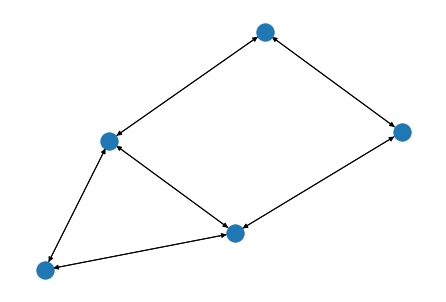

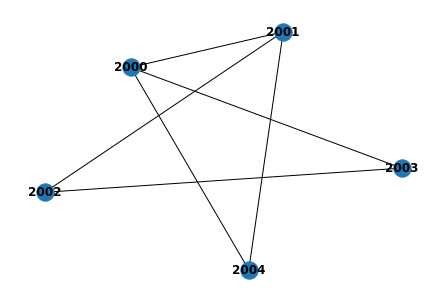

f1_score, ged 1.0 0.0
tree_node_x coalition [0, 2, 3, 4, 5]
tree_node_x.data.edge_index tensor([[0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5],
        [3, 2, 4, 5, 1, 3, 5, 0, 2, 4, 1, 3, 1, 2]])
ret_edge_index tensor([[0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5],
        [3, 2, 4, 5, 1, 3, 5, 0, 2, 4, 1, 3, 1, 2]])
mask_node_list [0, 2, 3, 4, 5]
[0 0 0 ... 0 0 0]


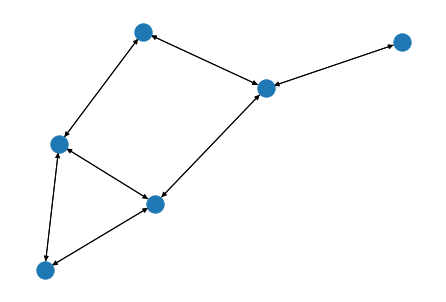

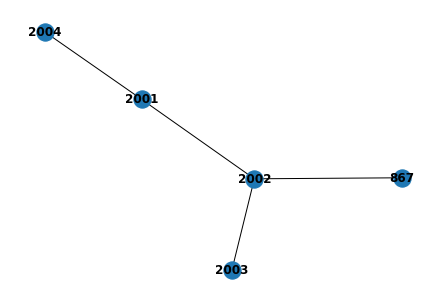

f1_score, ged 0.6 2.0
tree_node_x coalition [4, 5, 7, 10, 16, 17]
tree_node_x.data.edge_index tensor([[ 0,  0,  1,  2,  3,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
          5,  5,  6,  7,  8,  9, 10, 11, 12, 12, 13, 14, 14, 14, 15, 15, 15, 16,
         16, 16, 17, 17, 18, 18],
        [ 5, 12,  5,  5,  5,  5,  0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12,
         13, 16,  5,  5,  5,  5,  5,  5,  0,  5,  5, 15, 17, 18, 14, 16, 18,  5,
         15, 17, 14, 16, 14, 15]])
ret_edge_index tensor([[ 0,  0,  1,  2,  3,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
          5,  5,  6,  7,  8,  9, 10, 11, 12, 12, 13, 14, 14, 14, 15, 15, 15, 16,
         16, 16, 17, 17, 18, 18],
        [ 5, 12,  5,  5,  5,  5,  0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12,
         13, 16,  5,  5,  5,  5,  5,  5,  0,  5,  5, 15, 17, 18, 14, 16, 18,  5,
         15, 17, 14, 16, 14, 15]])
mask_node_list [4, 5, 7, 10, 16, 17]
[0 0 0 ... 0 0 0]


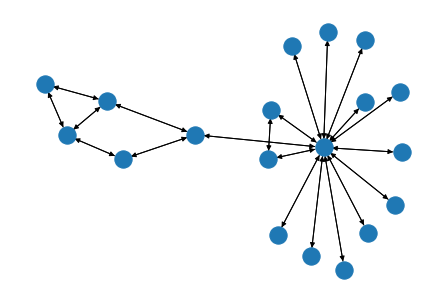

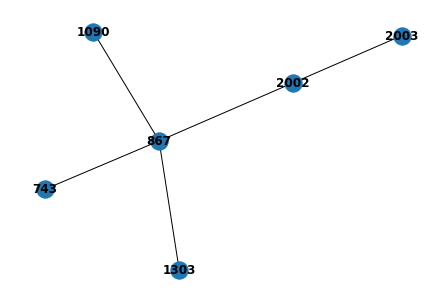

f1_score, ged 0.1818181818181818 4.0
tree_node_x coalition [0, 2, 3, 4, 5]
tree_node_x.data.edge_index tensor([[0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5],
        [3, 2, 4, 5, 1, 3, 5, 0, 2, 4, 1, 3, 1, 2]])
ret_edge_index tensor([[0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5],
        [3, 2, 4, 5, 1, 3, 5, 0, 2, 4, 1, 3, 1, 2]])
mask_node_list [0, 2, 3, 4, 5]
[0 0 0 ... 0 0 0]


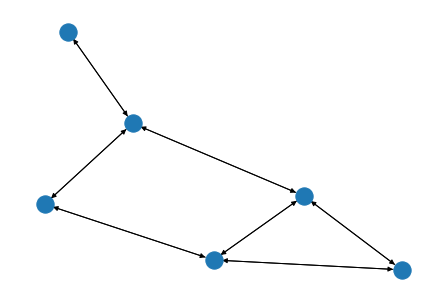

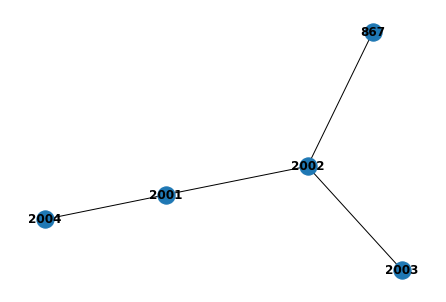

f1_score, ged 0.6 2.0
tree_node_x coalition [0, 1, 2, 3, 4]
tree_node_x.data.edge_index tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
        [1, 3, 4, 0, 2, 4, 1, 3, 0, 2, 0, 1]])
ret_edge_index tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
        [1, 3, 4, 0, 2, 4, 1, 3, 0, 2, 0, 1]])
mask_node_list [0, 1, 2, 3, 4]
[0 0 0 ... 0 0 0]


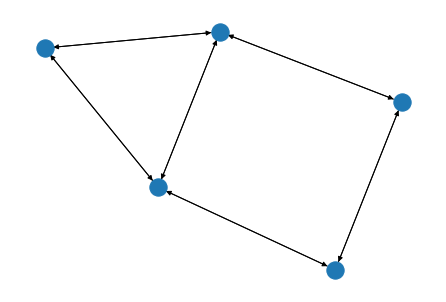

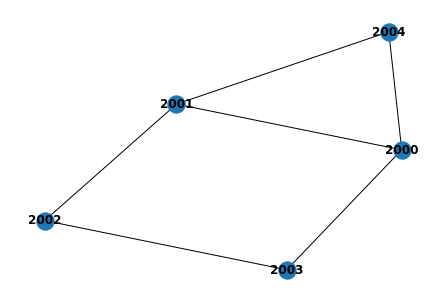

f1_score, ged 1.0 0.0
tree_node_x coalition [1, 2, 3, 4, 5]
tree_node_x.data.edge_index tensor([[0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5],
        [5, 2, 4, 5, 1, 3, 5, 2, 4, 1, 3, 0, 1, 2]])
ret_edge_index tensor([[0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5],
        [5, 2, 4, 5, 1, 3, 5, 2, 4, 1, 3, 0, 1, 2]])
mask_node_list [1, 2, 3, 4, 5]
[0 0 0 ... 0 0 0]


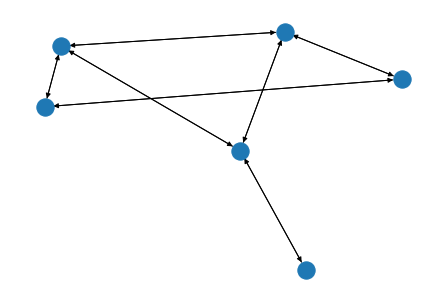

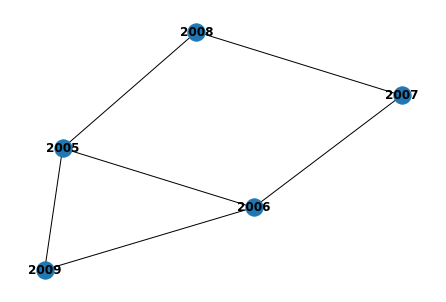

f1_score, ged 1.0 0.0
tree_node_x coalition [0, 2, 3, 4, 5]
tree_node_x.data.edge_index tensor([[0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5],
        [5, 2, 4, 5, 1, 3, 5, 2, 4, 1, 3, 0, 1, 2]])
ret_edge_index tensor([[0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5],
        [5, 2, 4, 5, 1, 3, 5, 2, 4, 1, 3, 0, 1, 2]])
mask_node_list [0, 2, 3, 4, 5]
[0 0 0 ... 0 0 0]


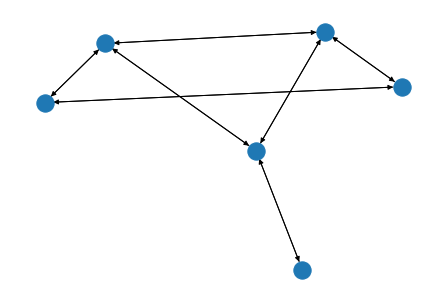

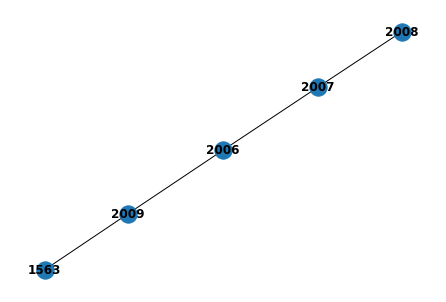

f1_score, ged 0.6 2.0
tree_node_x coalition [0, 1, 2, 3, 4]
tree_node_x.data.edge_index tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
        [1, 3, 4, 0, 2, 4, 1, 3, 0, 2, 0, 1]])
ret_edge_index tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
        [1, 3, 4, 0, 2, 4, 1, 3, 0, 2, 0, 1]])
mask_node_list [0, 1, 2, 3, 4]
[0 0 0 ... 0 0 0]


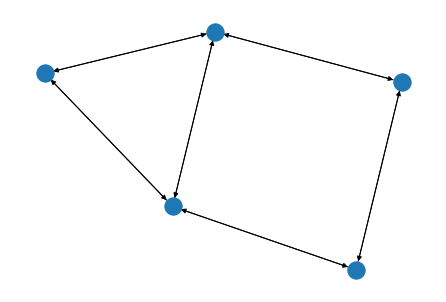

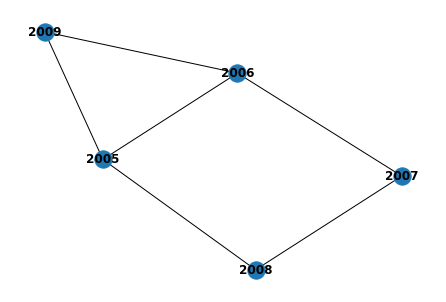

f1_score, ged 1.0 0.0
tree_node_x coalition [0, 1, 2, 3, 4]
tree_node_x.data.edge_index tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
        [1, 3, 4, 0, 2, 4, 1, 3, 0, 2, 0, 1]])
ret_edge_index tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
        [1, 3, 4, 0, 2, 4, 1, 3, 0, 2, 0, 1]])
mask_node_list [0, 1, 2, 3, 4]
[0 0 0 ... 0 0 0]


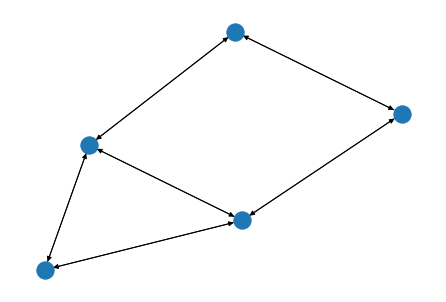

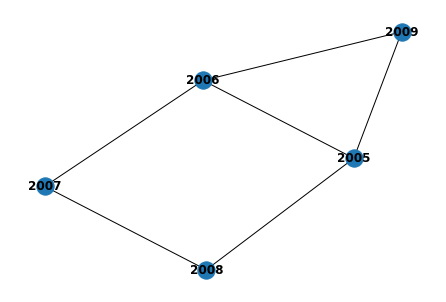

f1_score, ged 1.0 0.0
tree_node_x coalition [0, 4, 5, 6, 7, 11]
tree_node_x.data.edge_index tensor([[ 0,  0,  0,  1,  1,  2,  2,  3,  4,  5,  5,  5,  5,  5,  5,  5,  6,  7,
          7,  7,  8,  8,  8,  9,  9, 10, 10, 11, 11, 11],
        [ 1,  2,  5,  0,  5,  0,  5,  5,  5,  0,  1,  2,  3,  4,  6, 11,  5,  8,
         10, 11,  7,  9, 11,  8, 10,  7,  9,  5,  7,  8]])
ret_edge_index tensor([[ 0,  0,  0,  1,  1,  2,  2,  3,  4,  5,  5,  5,  5,  5,  5,  5,  6,  7,
          7,  7,  8,  8,  8,  9,  9, 10, 10, 11, 11, 11],
        [ 1,  2,  5,  0,  5,  0,  5,  5,  5,  0,  1,  2,  3,  4,  6, 11,  5,  8,
         10, 11,  7,  9, 11,  8, 10,  7,  9,  5,  7,  8]])
mask_node_list [0, 4, 5, 6, 7, 11]
[0 0 0 ... 0 0 0]


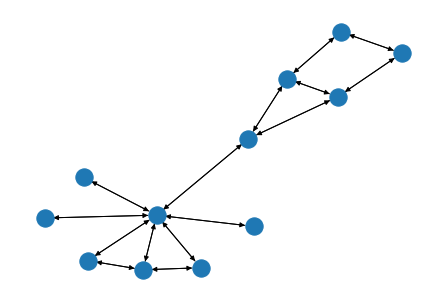

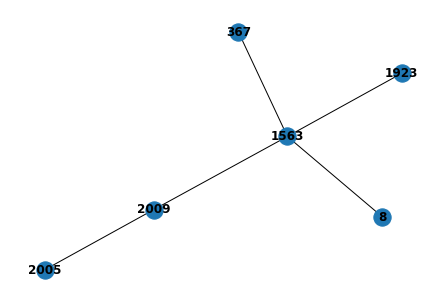

f1_score, ged 0.1818181818181818 4.0
tree_node_x coalition [1, 2, 3, 4, 5]
tree_node_x.data.edge_index tensor([[0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5],
        [2, 2, 4, 5, 0, 1, 3, 5, 2, 4, 1, 3, 1, 2]])
ret_edge_index tensor([[0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5],
        [2, 2, 4, 5, 0, 1, 3, 5, 2, 4, 1, 3, 1, 2]])
mask_node_list [1, 2, 3, 4, 5]
[0 0 0 ... 0 0 0]


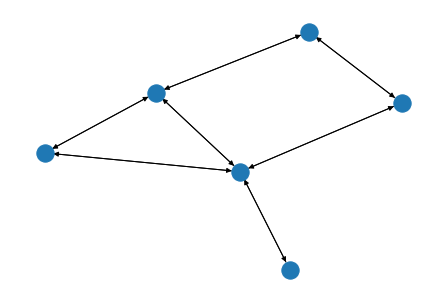

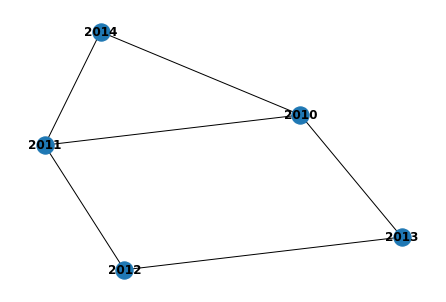

f1_score, ged 1.0 0.0
tree_node_x coalition [0, 1, 5, 7, 8, 10]
tree_node_x.data.edge_index tensor([[ 0,  1,  2,  3,  4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,
          8,  8,  9,  9, 10, 10],
        [ 5,  5,  5,  5,  5,  0,  1,  2,  3,  4,  7,  7,  9, 10,  5,  6,  8, 10,
          7,  9,  6,  8,  6,  7]])
ret_edge_index tensor([[ 0,  1,  2,  3,  4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,
          8,  8,  9,  9, 10, 10],
        [ 5,  5,  5,  5,  5,  0,  1,  2,  3,  4,  7,  7,  9, 10,  5,  6,  8, 10,
          7,  9,  6,  8,  6,  7]])
mask_node_list [0, 1, 5, 7, 8, 10]
[0 0 0 ... 0 0 0]


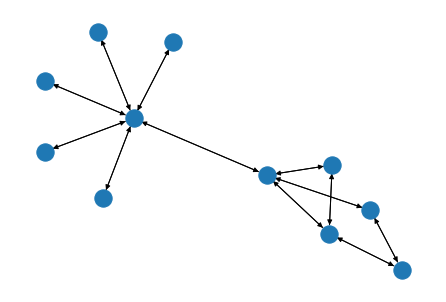

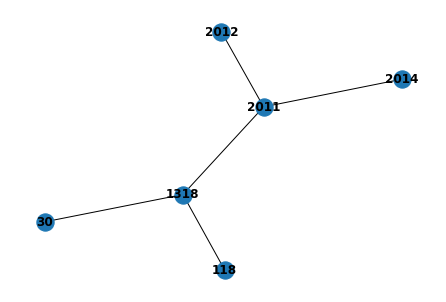

f1_score, ged 0.3636363636363636 4.0
tree_node_x coalition [1, 2, 3, 4, 5]
tree_node_x.data.edge_index tensor([[0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5],
        [2, 2, 4, 5, 0, 1, 3, 5, 2, 4, 1, 3, 1, 2]])
ret_edge_index tensor([[0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5],
        [2, 2, 4, 5, 0, 1, 3, 5, 2, 4, 1, 3, 1, 2]])
mask_node_list [1, 2, 3, 4, 5]
[0 0 0 ... 0 0 0]


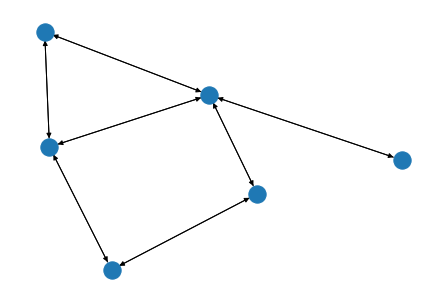

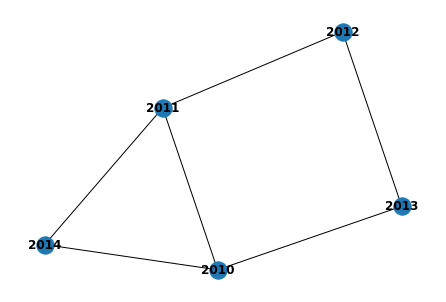

f1_score, ged 1.0 0.0
tree_node_x coalition [0, 1, 2, 3, 4]
tree_node_x.data.edge_index tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
        [1, 3, 4, 0, 2, 4, 1, 3, 0, 2, 0, 1]])
ret_edge_index tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
        [1, 3, 4, 0, 2, 4, 1, 3, 0, 2, 0, 1]])
mask_node_list [0, 1, 2, 3, 4]
[0 0 0 ... 0 0 0]


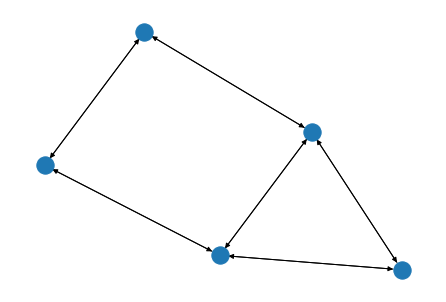

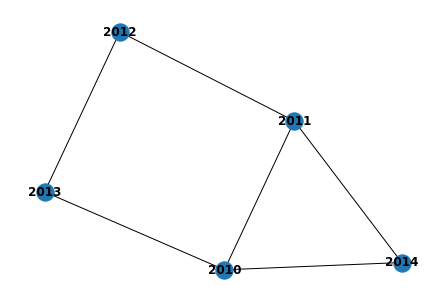

f1_score, ged 1.0 0.0
tree_node_x coalition [0, 1, 2, 3, 4, 5]
tree_node_x.data.edge_index tensor([[0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5],
        [2, 2, 4, 5, 0, 1, 3, 5, 2, 4, 1, 3, 1, 2]])
ret_edge_index tensor([[0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5],
        [2, 2, 4, 5, 0, 1, 3, 5, 2, 4, 1, 3, 1, 2]])
mask_node_list [0, 1, 2, 3, 4, 5]
[0 0 0 ... 0 0 0]


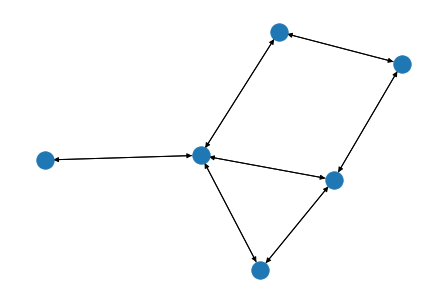

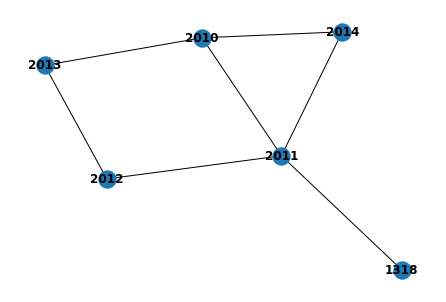

f1_score, ged 0.923076923076923 2.0
tree_node_x coalition [4, 5, 7, 8, 9, 11]
tree_node_x.data.edge_index tensor([[ 0,  1,  2,  3,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  7,  8,  8,  8,
          8,  9,  9,  9, 10, 10, 11, 11, 12, 12],
        [ 5,  5,  5,  5,  5,  0,  1,  2,  3,  4,  6,  7,  8,  5,  5,  5,  9, 11,
         12,  8, 10, 12,  9, 11,  8, 10,  8,  9]])
ret_edge_index tensor([[ 0,  1,  2,  3,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  7,  8,  8,  8,
          8,  9,  9,  9, 10, 10, 11, 11, 12, 12],
        [ 5,  5,  5,  5,  5,  0,  1,  2,  3,  4,  6,  7,  8,  5,  5,  5,  9, 11,
         12,  8, 10, 12,  9, 11,  8, 10,  8,  9]])
mask_node_list [4, 5, 7, 8, 9, 11]
[0 0 0 ... 0 0 0]


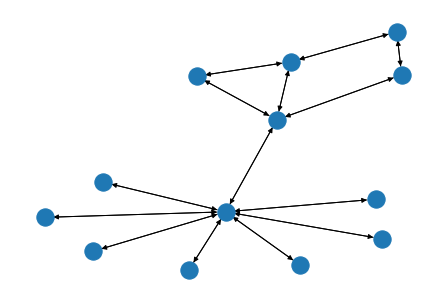

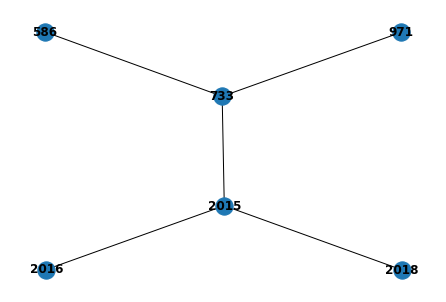

f1_score, ged 0.3636363636363636 4.0
tree_node_x coalition [0, 1, 2, 4, 5]
tree_node_x.data.edge_index tensor([[0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5],
        [1, 0, 2, 4, 5, 1, 3, 5, 2, 4, 1, 3, 1, 2]])
ret_edge_index tensor([[0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5],
        [1, 0, 2, 4, 5, 1, 3, 5, 2, 4, 1, 3, 1, 2]])
mask_node_list [0, 1, 2, 4, 5]
[0 0 0 ... 0 0 0]


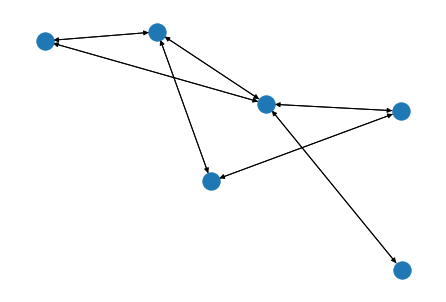

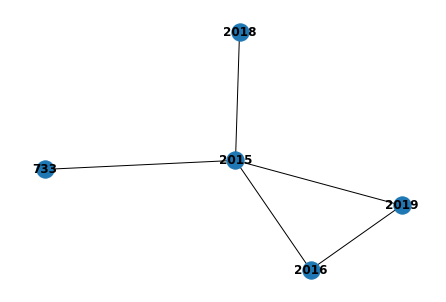

f1_score, ged 0.7272727272727272 3.0
tree_node_x coalition [0, 1, 2, 3, 4]
tree_node_x.data.edge_index tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
        [1, 3, 4, 0, 2, 4, 1, 3, 0, 2, 0, 1]])
ret_edge_index tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
        [1, 3, 4, 0, 2, 4, 1, 3, 0, 2, 0, 1]])
mask_node_list [0, 1, 2, 3, 4]
[0 0 0 ... 0 0 0]


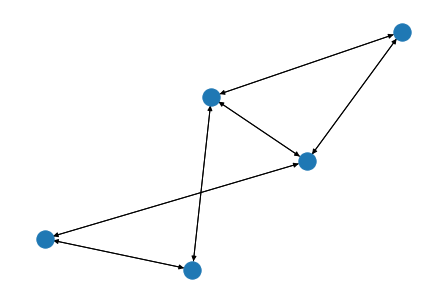

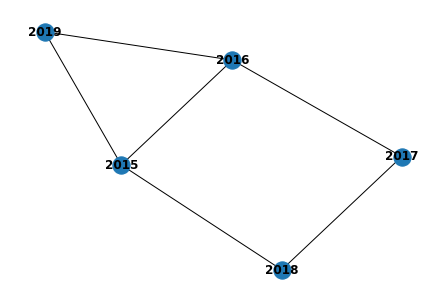

f1_score, ged 1.0 0.0
tree_node_x coalition [0, 1, 2, 4, 5]
tree_node_x.data.edge_index tensor([[0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5],
        [1, 0, 2, 4, 5, 1, 3, 5, 2, 4, 1, 3, 1, 2]])
ret_edge_index tensor([[0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5],
        [1, 0, 2, 4, 5, 1, 3, 5, 2, 4, 1, 3, 1, 2]])
mask_node_list [0, 1, 2, 4, 5]
[0 0 0 ... 0 0 0]


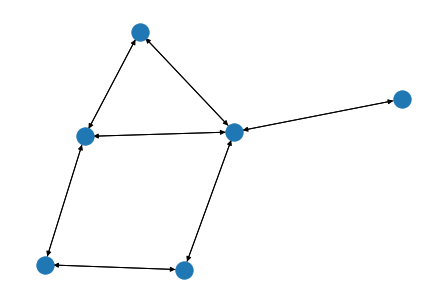

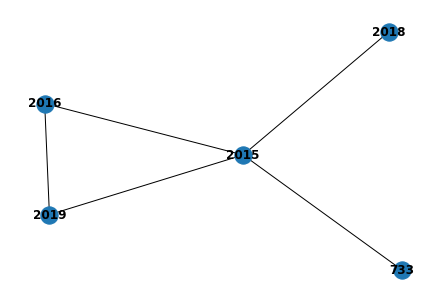

f1_score, ged 0.7272727272727272 3.0
tree_node_x coalition [0, 1, 2, 4, 5]
tree_node_x.data.edge_index tensor([[0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5],
        [1, 0, 2, 4, 5, 1, 3, 5, 2, 4, 1, 3, 1, 2]])
ret_edge_index tensor([[0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5],
        [1, 0, 2, 4, 5, 1, 3, 5, 2, 4, 1, 3, 1, 2]])
mask_node_list [0, 1, 2, 4, 5]
[0 0 0 ... 0 0 0]


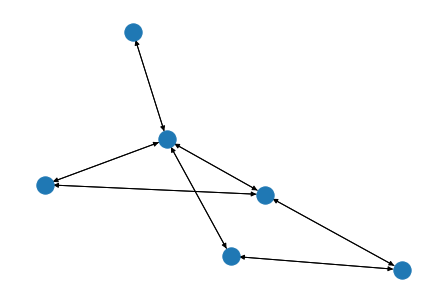

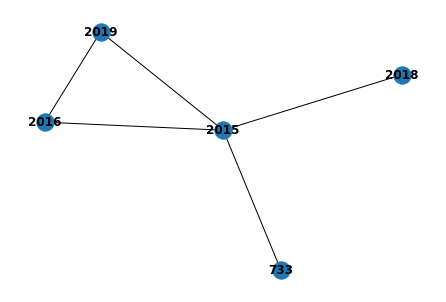

f1_score, ged 0.7272727272727272 3.0


<Figure size 432x288 with 0 Axes>

In [79]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    subgraphx = SubgraphX(model,
                              data.num_classes,
                              device,
                              explain_graph=False)
    #explain_result, node_mask = \
    edge_mask = \
                subgraphx.explain(data.x, data.edge_index,
                                  max_nodes=6,
                                  label=labels[node_idx],
                                  node_idx=node_idx)
    
    print(edge_mask)#[1997:2007])
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = None)
    
    """
    print("node_mask shape", len(node_mask))
    print("node_mask", node_mask)
    print(explain_result[0]['data'].edge_index)
    print(subgraphx.mapping_inv)
    G_expl = to_networkx(explain_result[0]['data']).to_undirected()
    G_expl = nx.relabel_nodes(G_expl, subgraphx.mapping_inv)
    
    
    plt.figure(1,figsize=(14,12)) 
    #nx.draw(G_expl,node_size=75,linewidths=6)
    plt.show()
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    recall, precision, f1_score, ged = evaluate_subgraph(node_idx, data, G_expl)
    """
    
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [284]:
def evaluate_subgraph(node_idx, data, G_expl):
    G_true, role = get_ground_truth_ba_shapes(node_idx)
    #nx.draw(G_true,  with_labels=True, font_weight='bold')
    #plt.figure()
    #nx.draw(G_expl,  with_labels=True, font_weight='bold')
    #plt.show()
    #plt.clf()
    return scores(G_expl, G_true)

In [80]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision), np.mean(duration_samples))

0.7497902097902097 1.65 0.7249999999999999 0.785357142857143 nan


/Users/kenzaamara/.conda/envs/Explain/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kenzaamara/.conda/envs/Explain/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
